# Chapter 3

In [4]:
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import special, stats
import numpy as np

import theano as tt

import datetime
print(f"Last Run {datetime.datetime.now()}")

Last Run 2021-08-24 18:34:34.908641


In [5]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300

def plot_label_resizer(axes, fontsize=14):
    """Resizes the axes labels of plots"""
    for ax in axes.ravel():
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)
    return

In [7]:
penguins = pd.read_csv("../data/penguins.csv")

# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)

# Drop rows with any missing data
penguins = penguins.loc[~missing_data]

penguins.head()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
4  Adelie  Torgersen            36.7           19.3              193.0   
5  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g     sex  year  
0       3750.0    male  2007  
1       3800.0  female  2007  
2       3250.0  female  2007  
4       3450.0  female  2007  
5       3650.0    male  2007

In [8]:
penguins.shape

(333, 8)

In [9]:
summary_stats = (penguins.loc[:, ["species", "body_mass_g"]]
                         .groupby("species")
                         .agg(["mean", "std", "count"]))
summary_stats

body_mass_g                  
                  mean         std count
species                                 
Adelie     3706.164384  458.620135   146
Chinstrap  3733.088235  384.335081    68
Gentoo     5092.436975  501.476154   119

## Adelie Penguin Mass Only

In [10]:
adelie_mask = (penguins["species"] == "Adelie")
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values

with pm.Model() as model_adelie_penguin_mass:
    σ = pm.HalfStudentT("σ", 100, 2000)
    μ = pm.Normal("μ", 4000, 3000)
    mass = pm.Normal("mass", mu=μ, sd=σ, observed=adelie_mass_obs)

    prior = pm.sample_prior_predictive(samples=5000)
    trace = pm.sample(random_seed=0)
    inf_data_adelie_penguin_mass = az.from_pymc3(prior=prior, trace=trace)

/var/folders/nf/ch8x562s5q30j7qbf07161qr0000gp/T/ipykernel_42739/3754138424.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(random_seed=0)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8867355236620349, but should be close to 0.8. Try to increase the number of tuning steps.


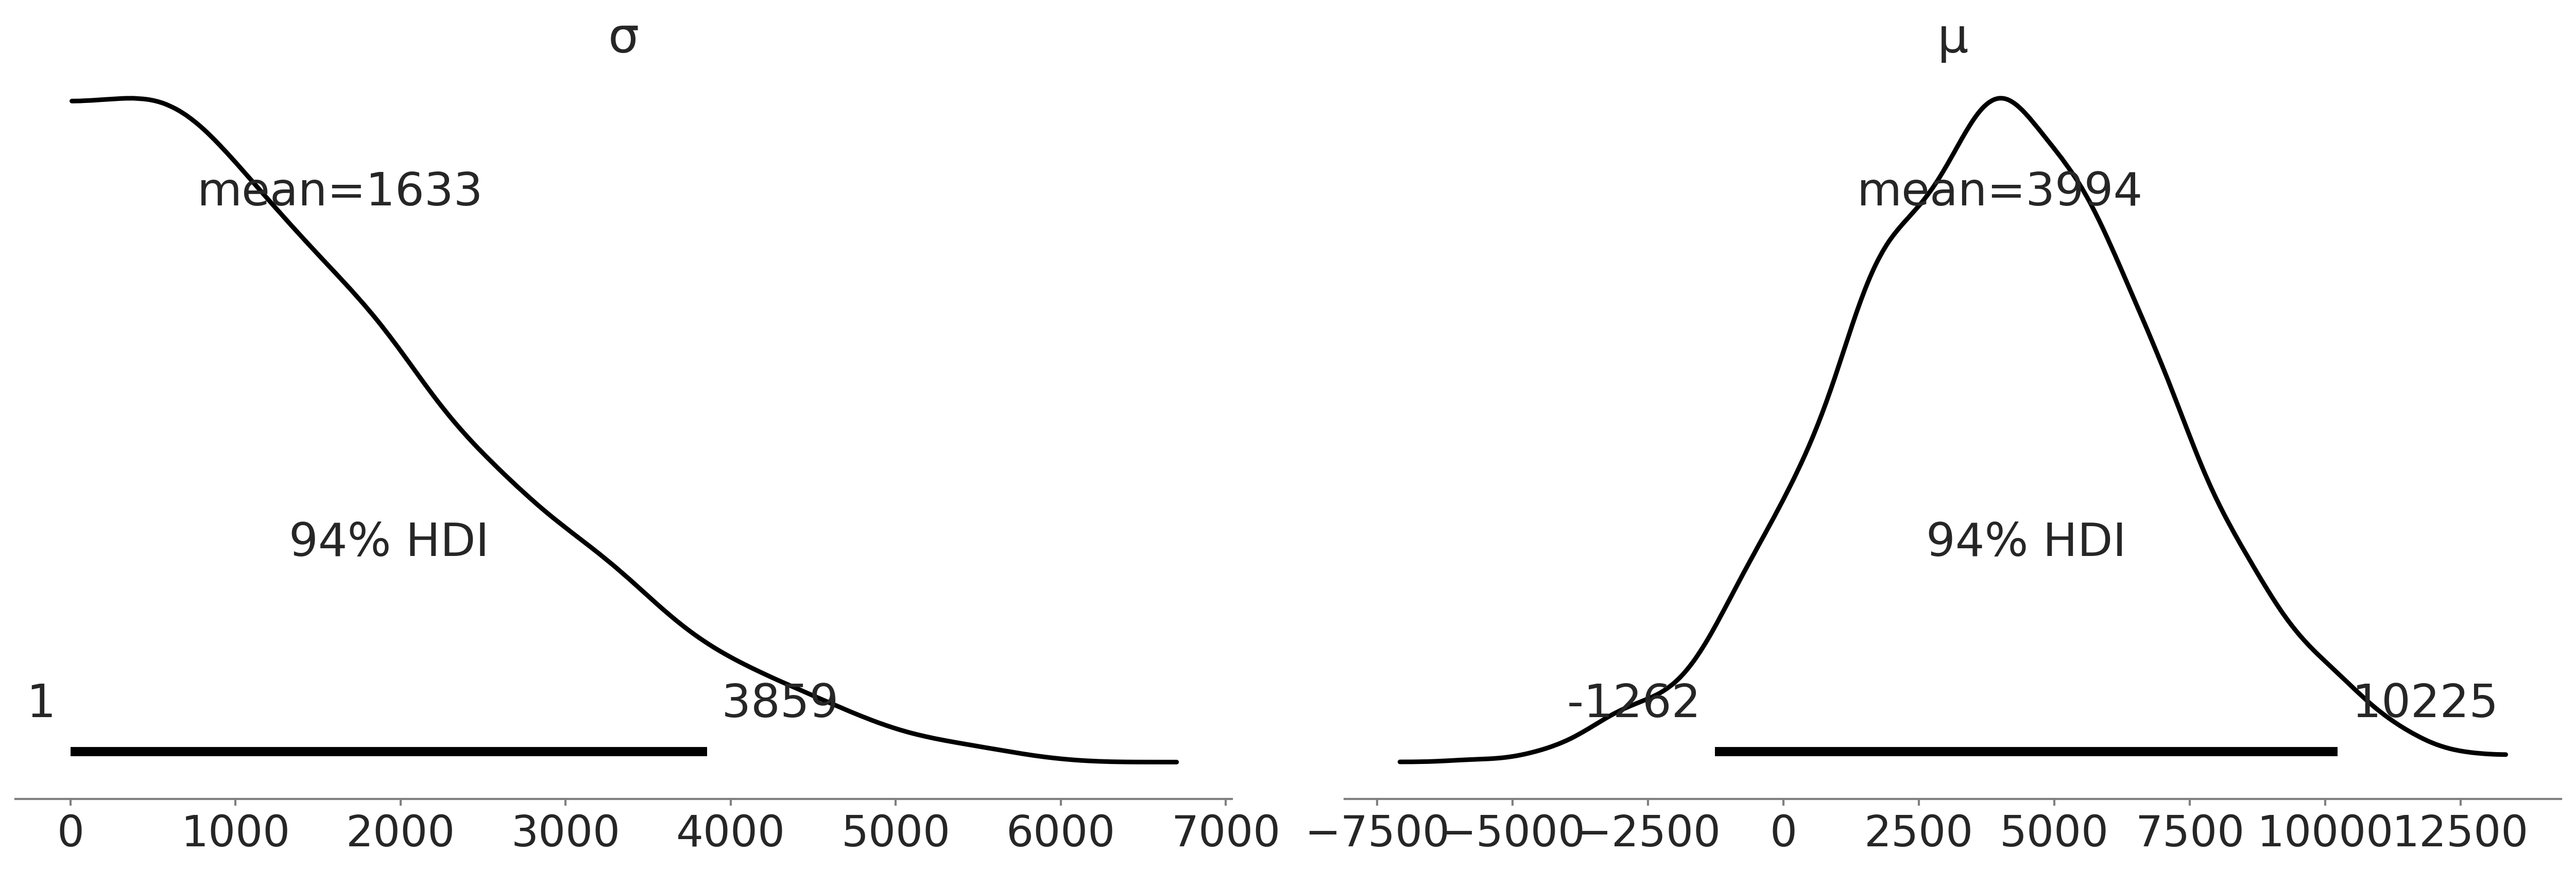

In [11]:
axes = az.plot_posterior(inf_data_adelie_penguin_mass.prior, var_names=["σ", "μ"], textsize=20)

# plt.savefig("img/SingleSpecies_Prior_Predictive.png")
plt.savefig("img/chp03/single_species_prior_predictive.png")

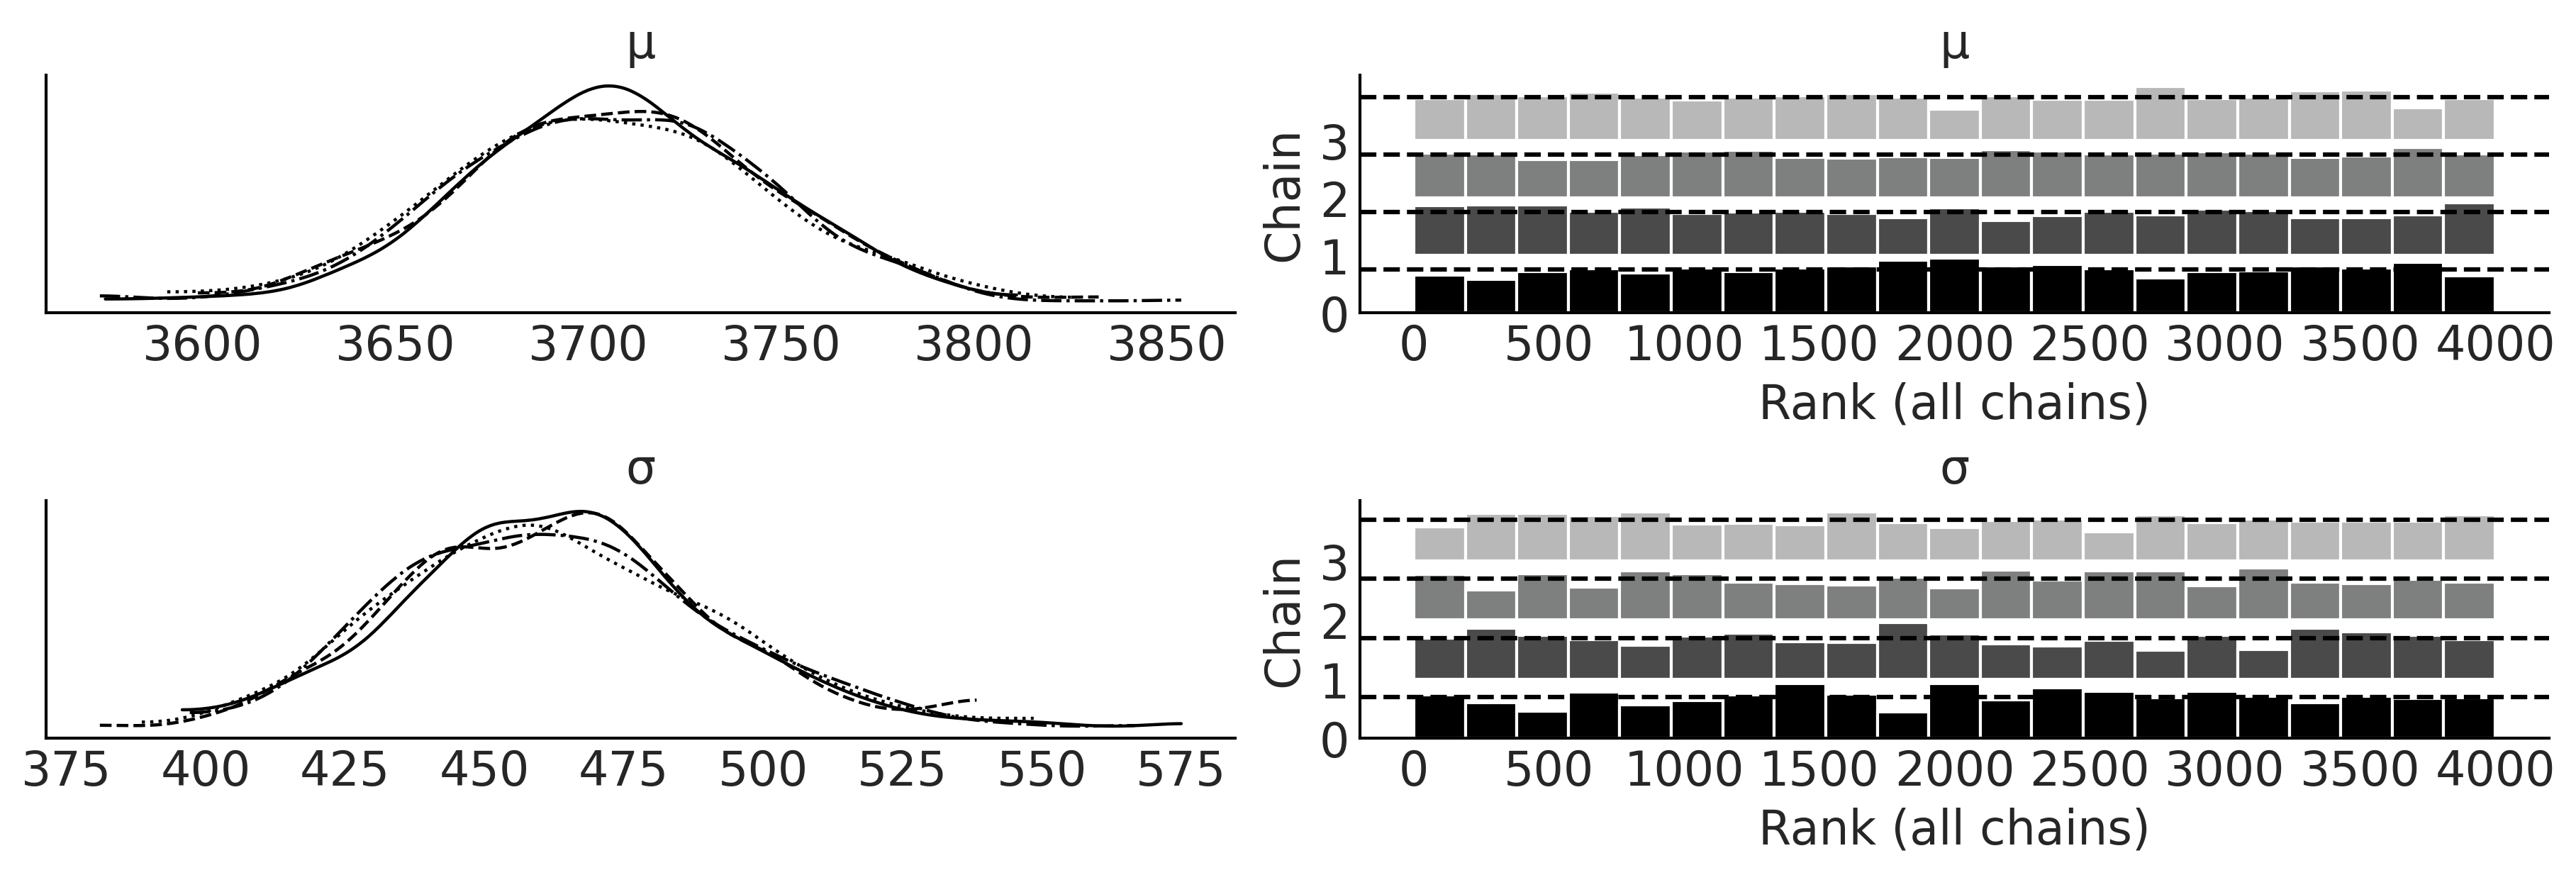

In [12]:
axes = az.plot_trace(inf_data_adelie_penguin_mass, divergences="bottom", kind="rank_bars")


plot_label_resizer(axes, fontsize=16)
# plt.savefig("img/SingleSpecies_KDE_RankPlot.png")
plt.savefig("img/chp03/single_species_KDE_rankplot.png")

In [13]:
az.summary(inf_data_adelie_penguin_mass)

mean      sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
μ  3706.442  38.927  3635.444  3780.938      0.654    0.463    3551.0   
σ   462.621  27.320   412.333   514.092      0.455    0.324    3664.0   

   ess_tail  r_hat  
μ    2380.0    1.0  
σ    2738.0    1.0

In [14]:
print(az.summary(inf_data_adelie_penguin_mass).round(1).to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &    mean &    sd &  hdi\_3\% &  hdi\_97\% &  mcse\_mean &  mcse\_sd &  ess\_bulk &  ess\_tail &  r\_hat \\
\midrule
μ &  3706.4 &  38.9 &  3635.4 &   3780.9 &        0.7 &      0.5 &    3551.0 &    2380.0 &    1.0 \\
σ &   462.6 &  27.3 &   412.3 &    514.1 &        0.5 &      0.3 &    3664.0 &    2738.0 &    1.0 \\
\bottomrule
\end{tabular}



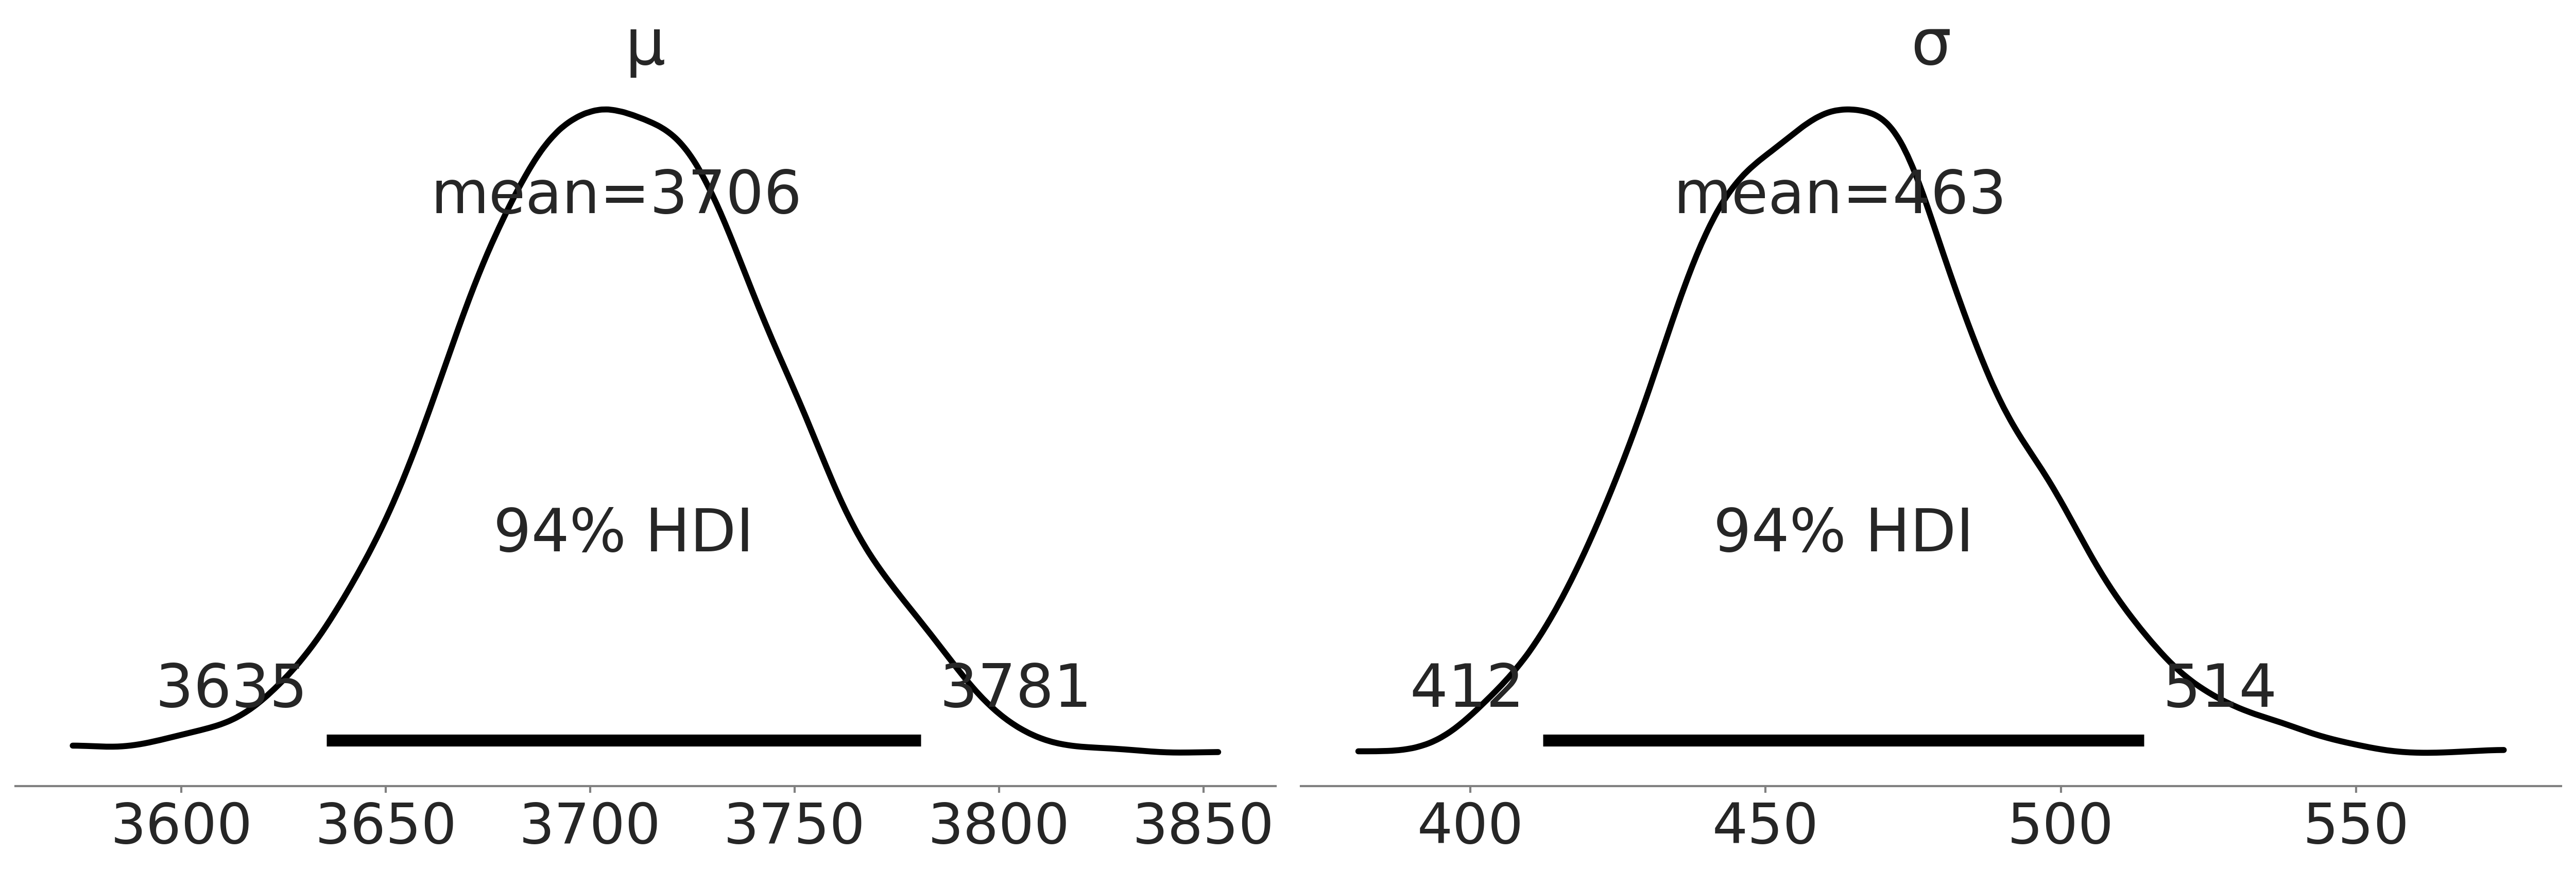

In [15]:
axes = az.plot_posterior(inf_data_adelie_penguin_mass, hdi_prob=.94, textsize=26);
# plt.savefig("img/SingleSpecies_Mass_PosteriorPlot.png")
plt.savefig("img/chp03/single_species_sass_posteriorplot.png")

In [16]:
all_species = pd.Categorical(penguins["species"])
all_species.categories

Index(['Adelie', 'Chinstrap', 'Gentoo'], dtype='object')

## All Penguin Species Mass

In [17]:
all_species = pd.Categorical(penguins["species"])

with pm.Model() as model_penguin_mass_all_species:
    σ = pm.HalfStudentT("σ", 100, 2000, shape=3)
    μ = pm.Normal("μ", 4000, 3000, shape=3)
    mass = pm.Normal("mass", mu=μ[all_species.codes], sd=σ[all_species.codes],
                     observed=penguins["body_mass_g"])

    trace = pm.sample(random_seed=0)
    inf_data_model_penguin_mass_all_species = az.from_pymc3(
        trace=trace,
        coords={"μ_dim_0": all_species.categories, "σ_dim_0": all_species.categories})

/var/folders/nf/ch8x562s5q30j7qbf07161qr0000gp/T/ipykernel_42739/1743603365.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(random_seed=0)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


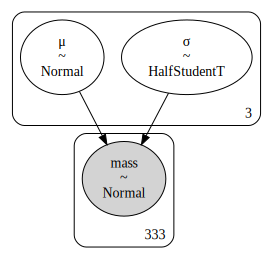

In [18]:
pm.model_to_graphviz(model_penguin_mass_all_species)

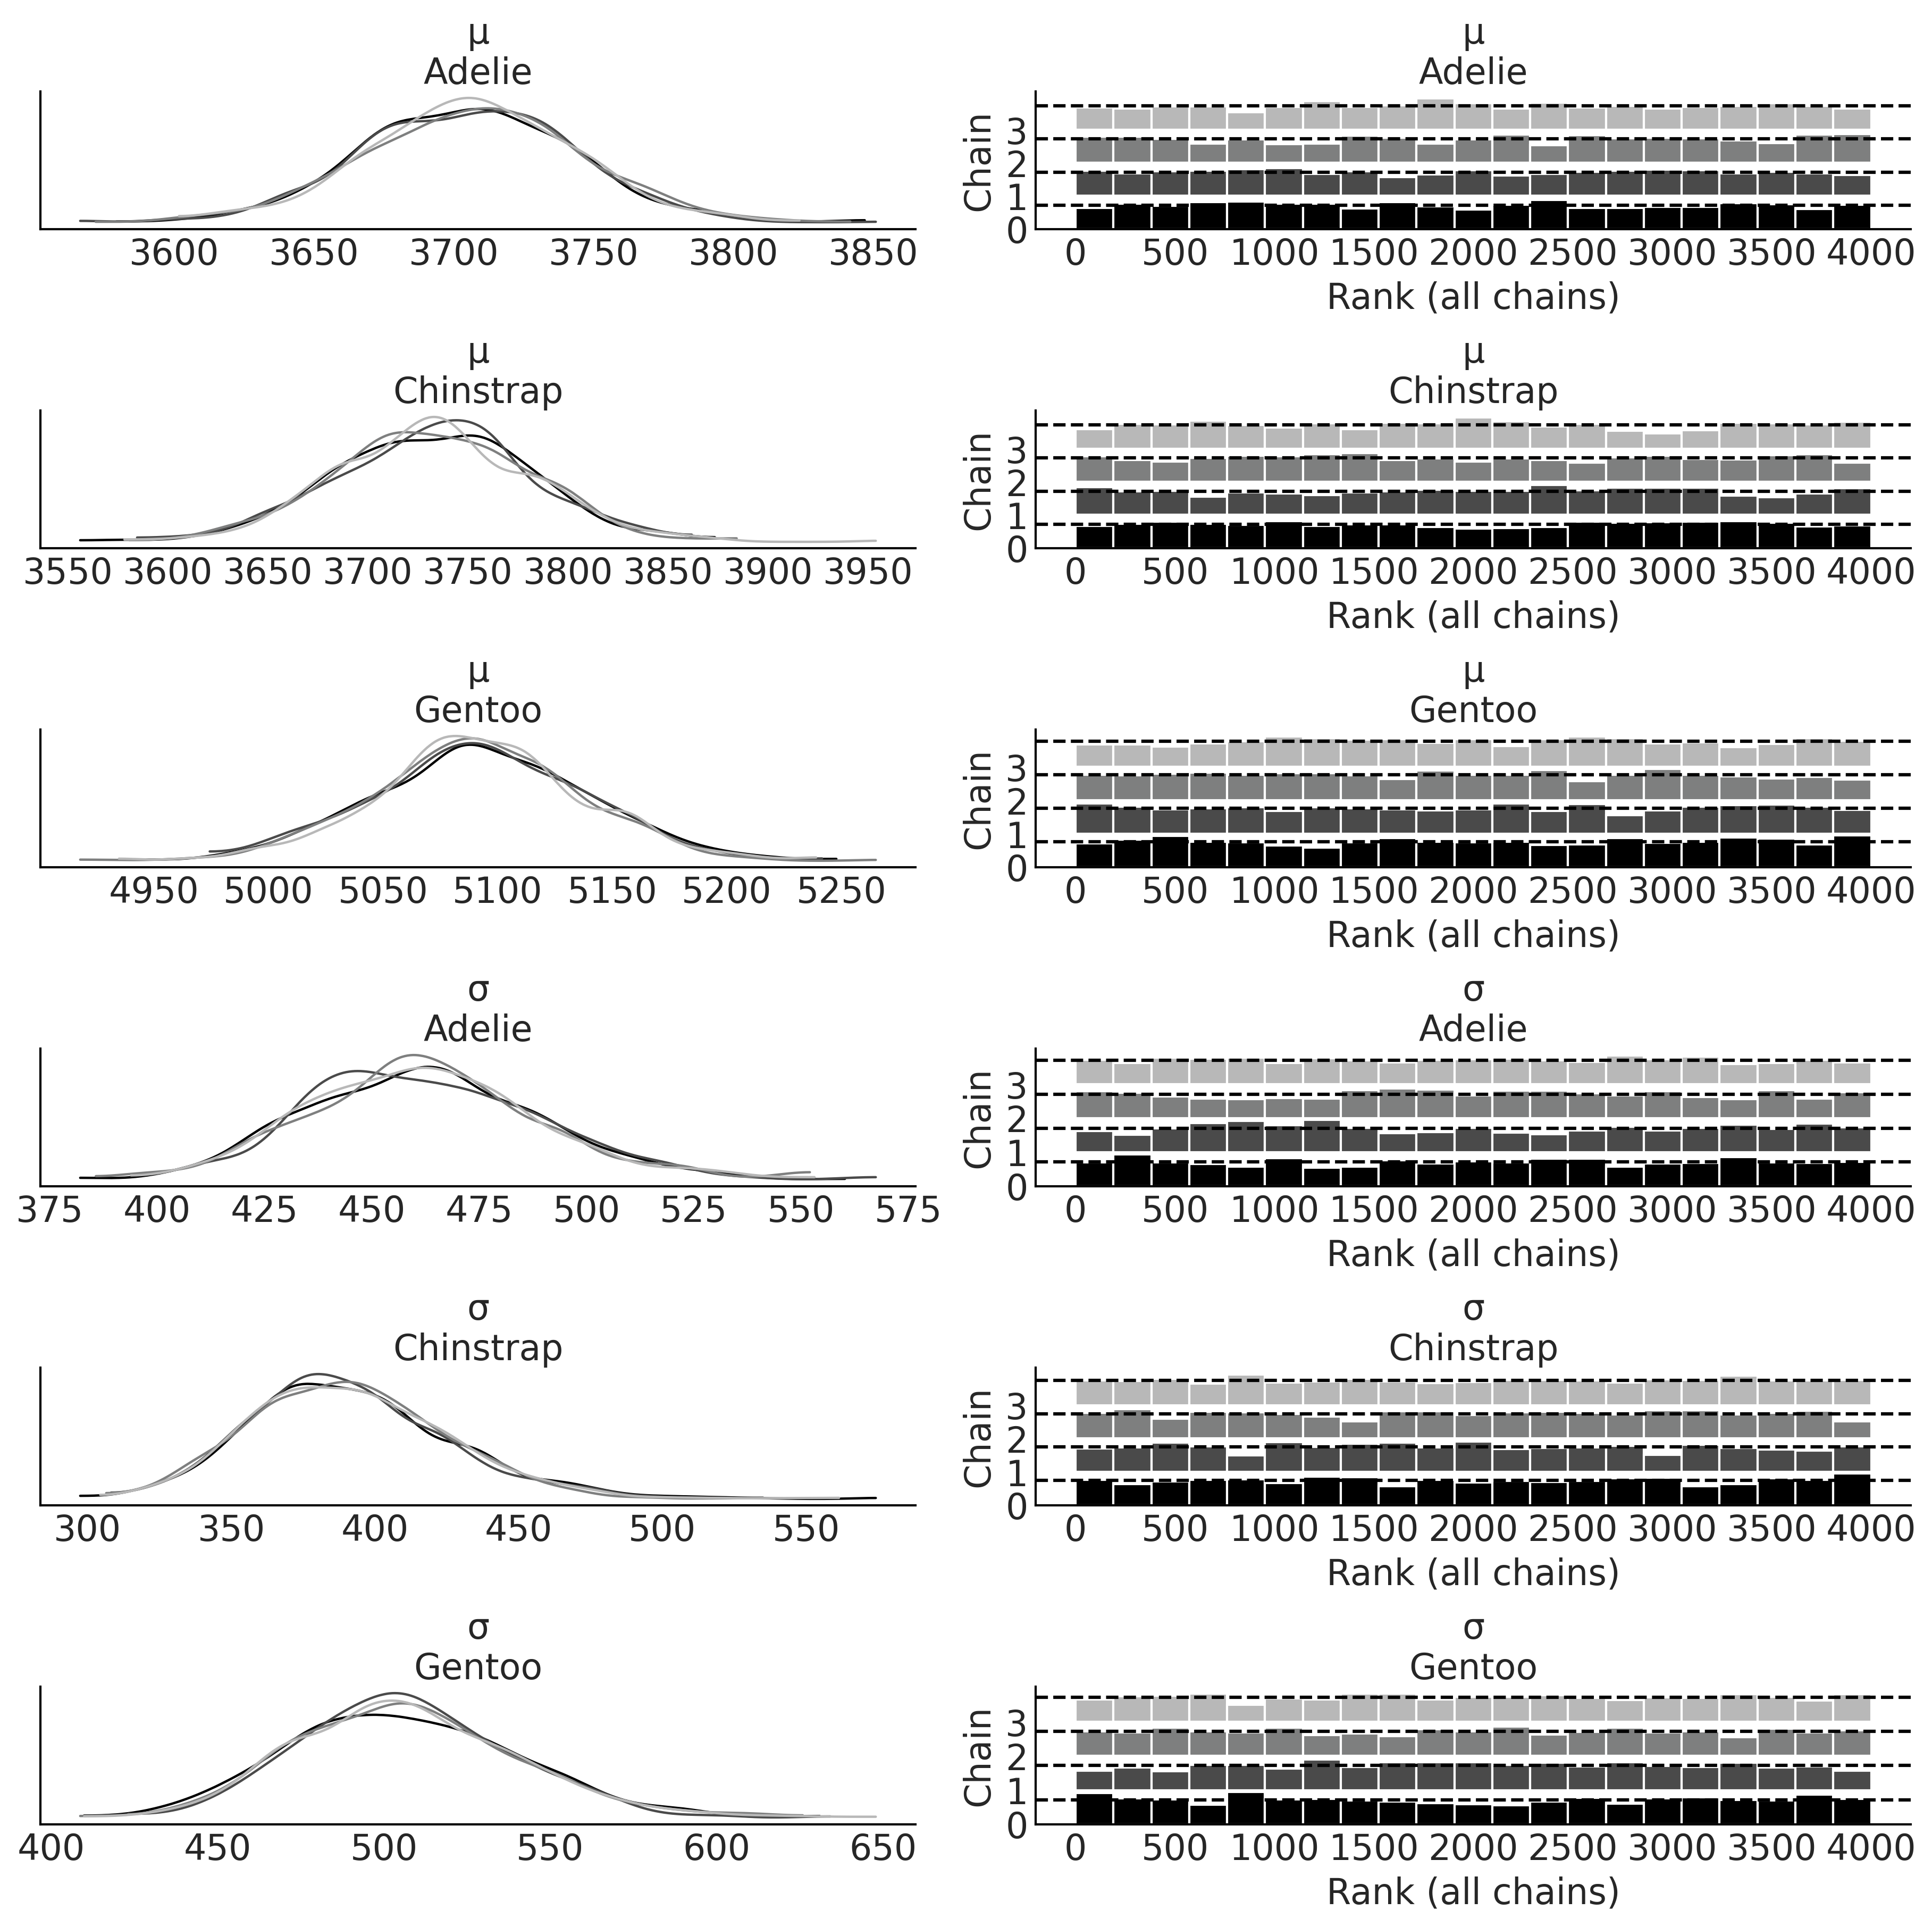

In [19]:
axes = az.plot_trace(inf_data_model_penguin_mass_all_species, compact=False, divergences="bottom", kind="rank_bars");

plot_label_resizer(axes, fontsize=16)
# plt.savefig("img/AllSpecies_KDE_RankPlot.png")
plt.savefig("img/chp03/all_species_KDE_rankplot.png")

While these plots do tell us the difference between the distributions it is hard to see so we we can plot these again using a forestplot.

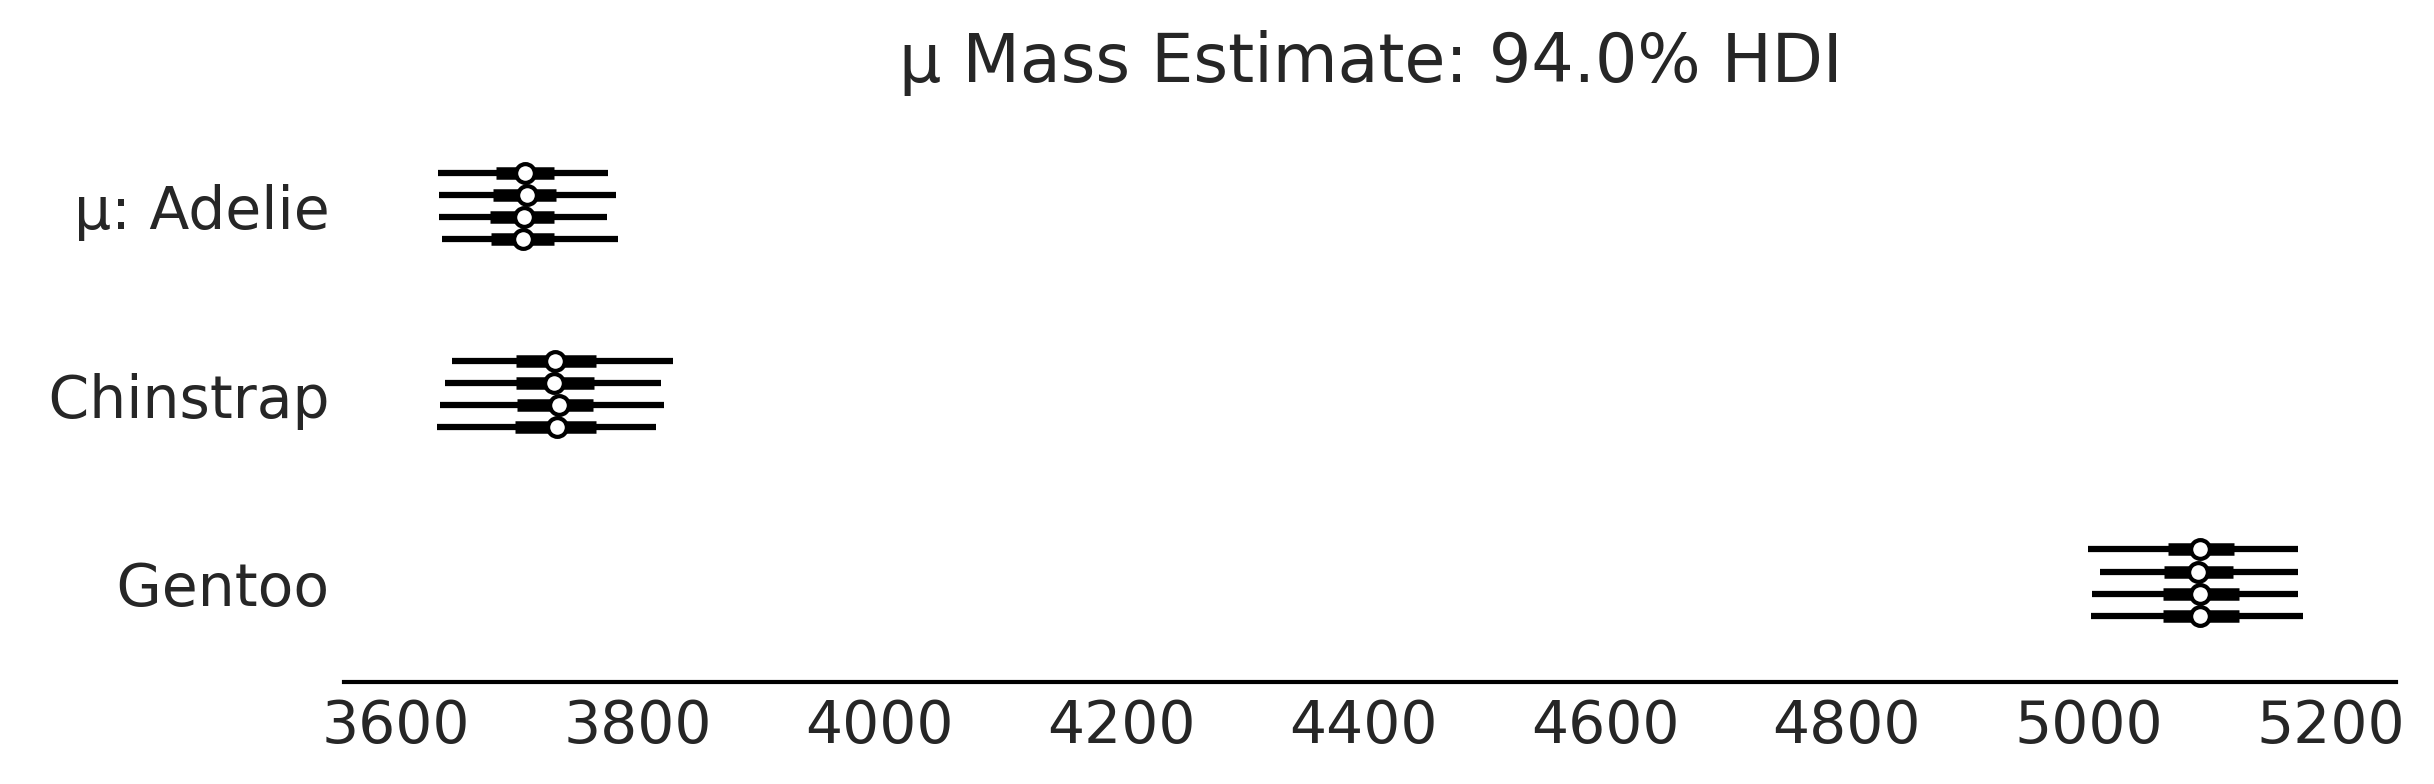

In [20]:
axes = az.plot_forest(inf_data_model_penguin_mass_all_species, var_names=["μ"], figsize=(8, 2.5))
axes[0].set_title("μ Mass Estimate: 94.0% HDI")
# plt.savefig("img/Independent_Model_ForestPlotMeans.png")
plt.savefig("img/chp03/independent_model_forestplotmeans.png")

This plot makes it much easier to compare our estimates, the Gentoo penguins are much heavier than the other two.  


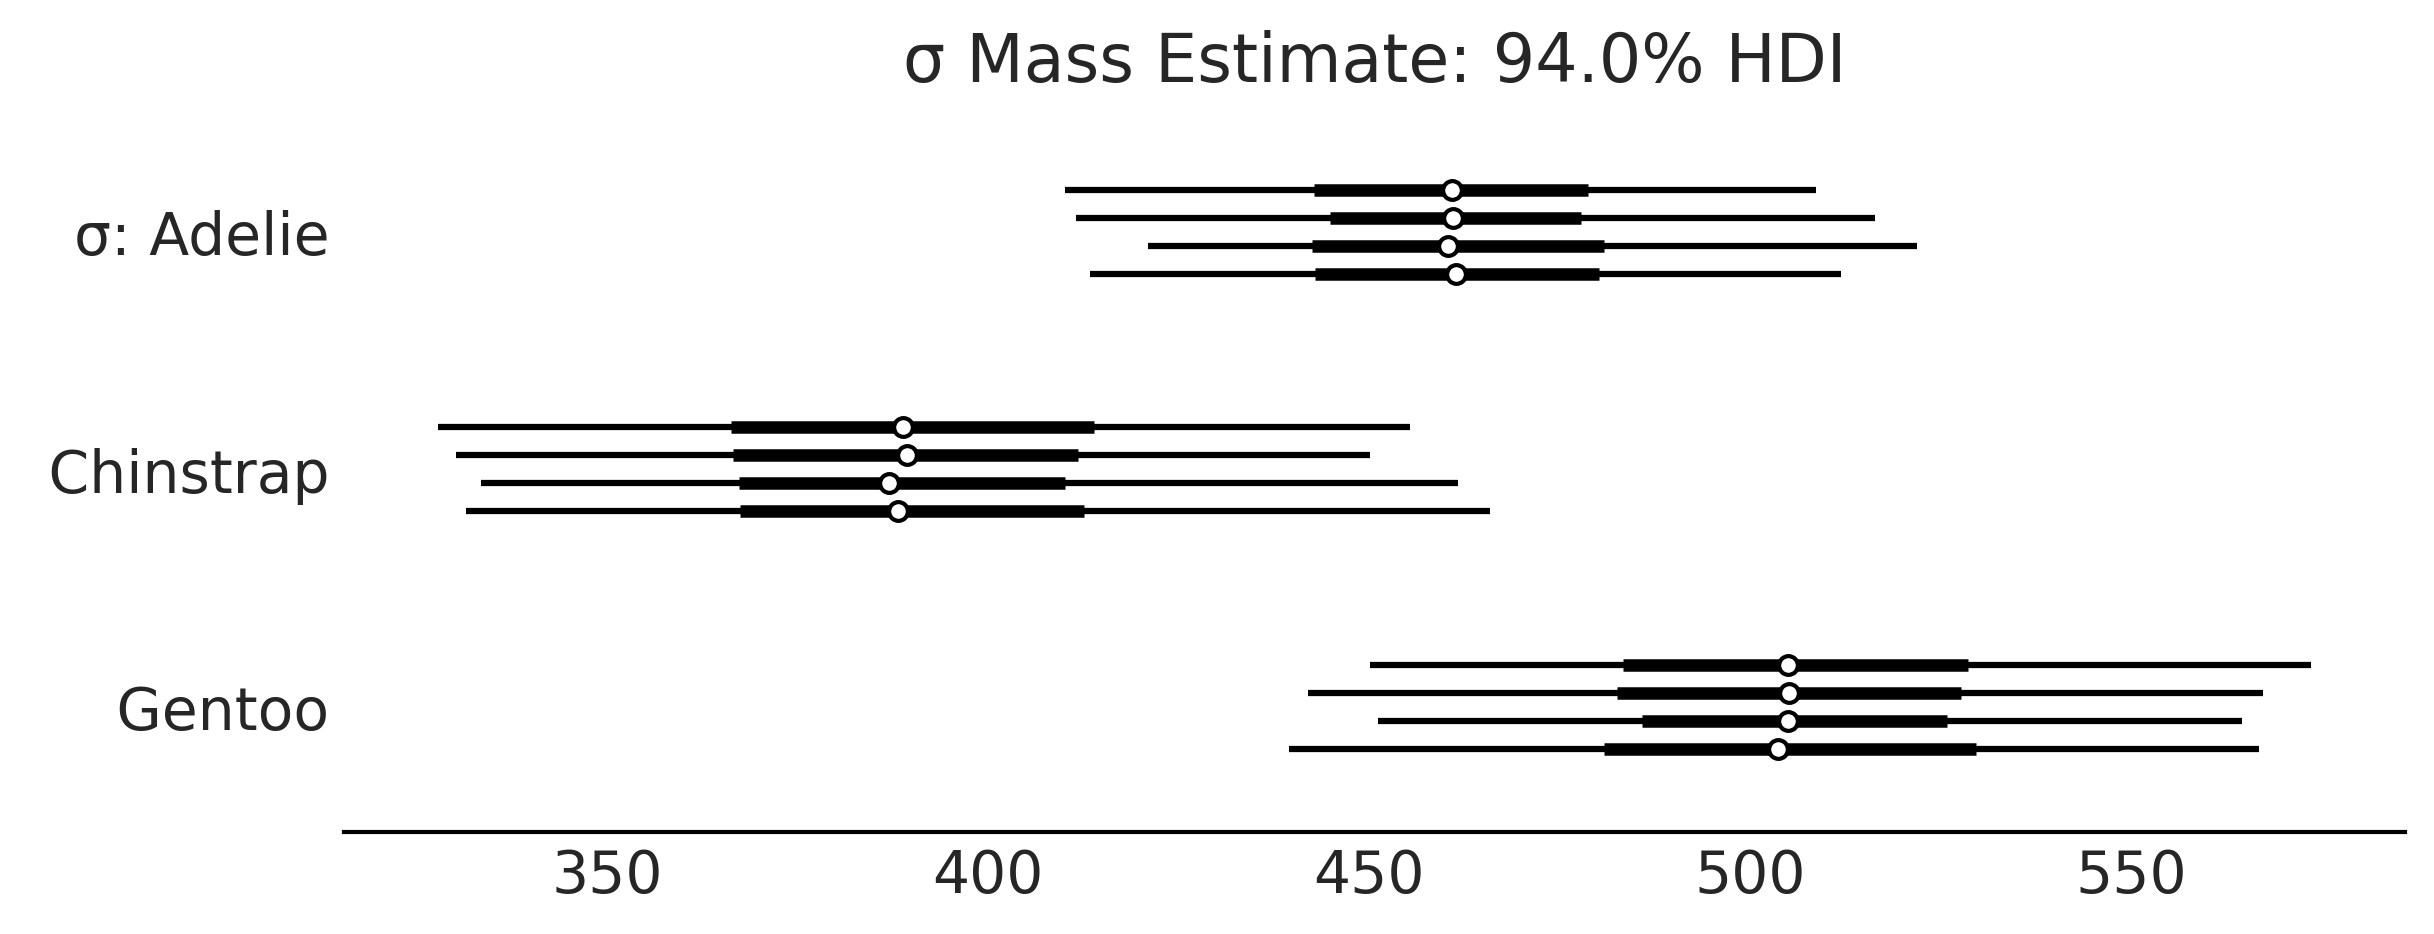

In [21]:
axes = az.plot_forest(inf_data_model_penguin_mass_all_species, var_names=["σ"], figsize=(8, 3));
axes[0].set_title("σ Mass Estimate: 94.0% HDI")

plt.savefig("img/chp03/independent_model_forestplotsigma.png")

## TFP penguin mass model

In [22]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
root = tfd.JointDistributionCoroutine.Root

species_idx = tf.constant(all_species.codes, tf.int32)
body_mass_g = tf.constant(penguins["body_mass_g"], tf.float32)

@tfd.JointDistributionCoroutine
def jd_penguin_mass_all_species():
    σ = yield root(tfd.Sample(
            tfd.HalfStudentT(df=100, loc=0, scale=2000),
            sample_shape=3,
            name='sigma'))
    μ = yield root(tfd.Sample(
            tfd.Normal(loc=4000, scale=3000),
            sample_shape=3,
            name='mu'))
    mass = yield tfd.Independent(
        tfd.Normal(loc=tf.gather(μ, species_idx, axis=-1),
                   scale=tf.gather(σ, species_idx, axis=-1)),
        reinterpreted_batch_ndims=1,
        name='mass')

2021-08-24 18:38:22.115469: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
prior_predictive_samples = jd_penguin_mass_all_species.sample(1000)

2021-08-24 18:38:22.293064: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [25]:
target_density_function = lambda *x: jd_penguin_mass_all_species.log_prob(
    *x, mass=body_mass_g)

jd_penguin_mass_observed = jd_penguin_mass_all_species.experimental_pin(
    mass=body_mass_g)
target_density_function = jd_penguin_mass_observed.unnormalized_log_prob

# init_state = jd_penguin_mass_observed.sample_unpinned(10)
# target_density_function1(*init_state), target_density_function2(*init_state)

In [26]:
run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts,
    autograph=False, jit_compile=True)
mcmc_samples, sampler_stats = run_mcmc(
    1000, jd_penguin_mass_all_species, n_chains=4, num_adaptation_steps=1000,
    mass=body_mass_g)

inf_data_model_penguin_mass_all_species2 = az.from_dict(
    posterior={
        k:np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]}
)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2021-08-24 18:38:53.513172: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x7f9e90009340 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-08-24 18:38:53.513193: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2021-08-24 18:38:55.734650: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2021-08-24 18:38:55.814452: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:96] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
2021-08-24 18:38:56.016200: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert
2021-08-24 18:40:12.185048: I tensorflow/compiler/jit/xla_compilat

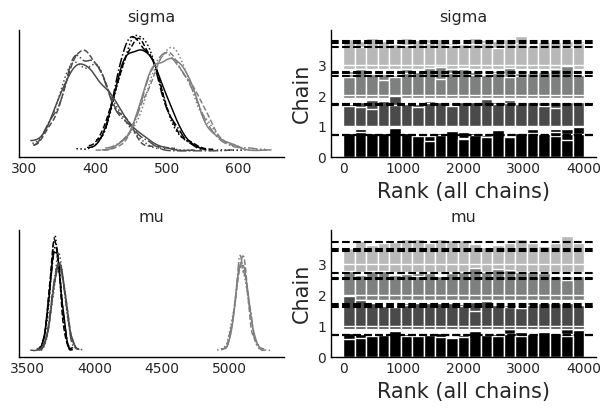

In [101]:
az.plot_trace(inf_data_model_penguin_mass_all_species2, divergences="bottom", kind="rank_bars", figsize=(6,4));

In [28]:
prior_predictive_samples = jd_penguin_mass_all_species.sample([1, 1000])
dist, samples = jd_penguin_mass_all_species.sample_distributions(
    value=mcmc_samples)
posterior_predictive_samples = samples[-1]
posterior_predictive_distribution = dist[-1].distribution
data_log_likelihood = posterior_predictive_distribution.log_prob(body_mass_g)

inf_data_model_penguin_mass_all_species2.add_groups(
    prior=prior_predictive_samples[:-1]._asdict(),
    prior_predictive={"mass": prior_predictive_samples[-1]},
    posterior_predictive={"mass": np.swapaxes(
        posterior_predictive_samples, 1, 0)},
    log_likelihood={"mass": np.swapaxes(data_log_likelihood, 1, 0)},
    observed_data={"mass": body_mass_g}
)

/Users/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/data/inference_data.py:1328: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


<AxesSubplot:xlabel='mass'>

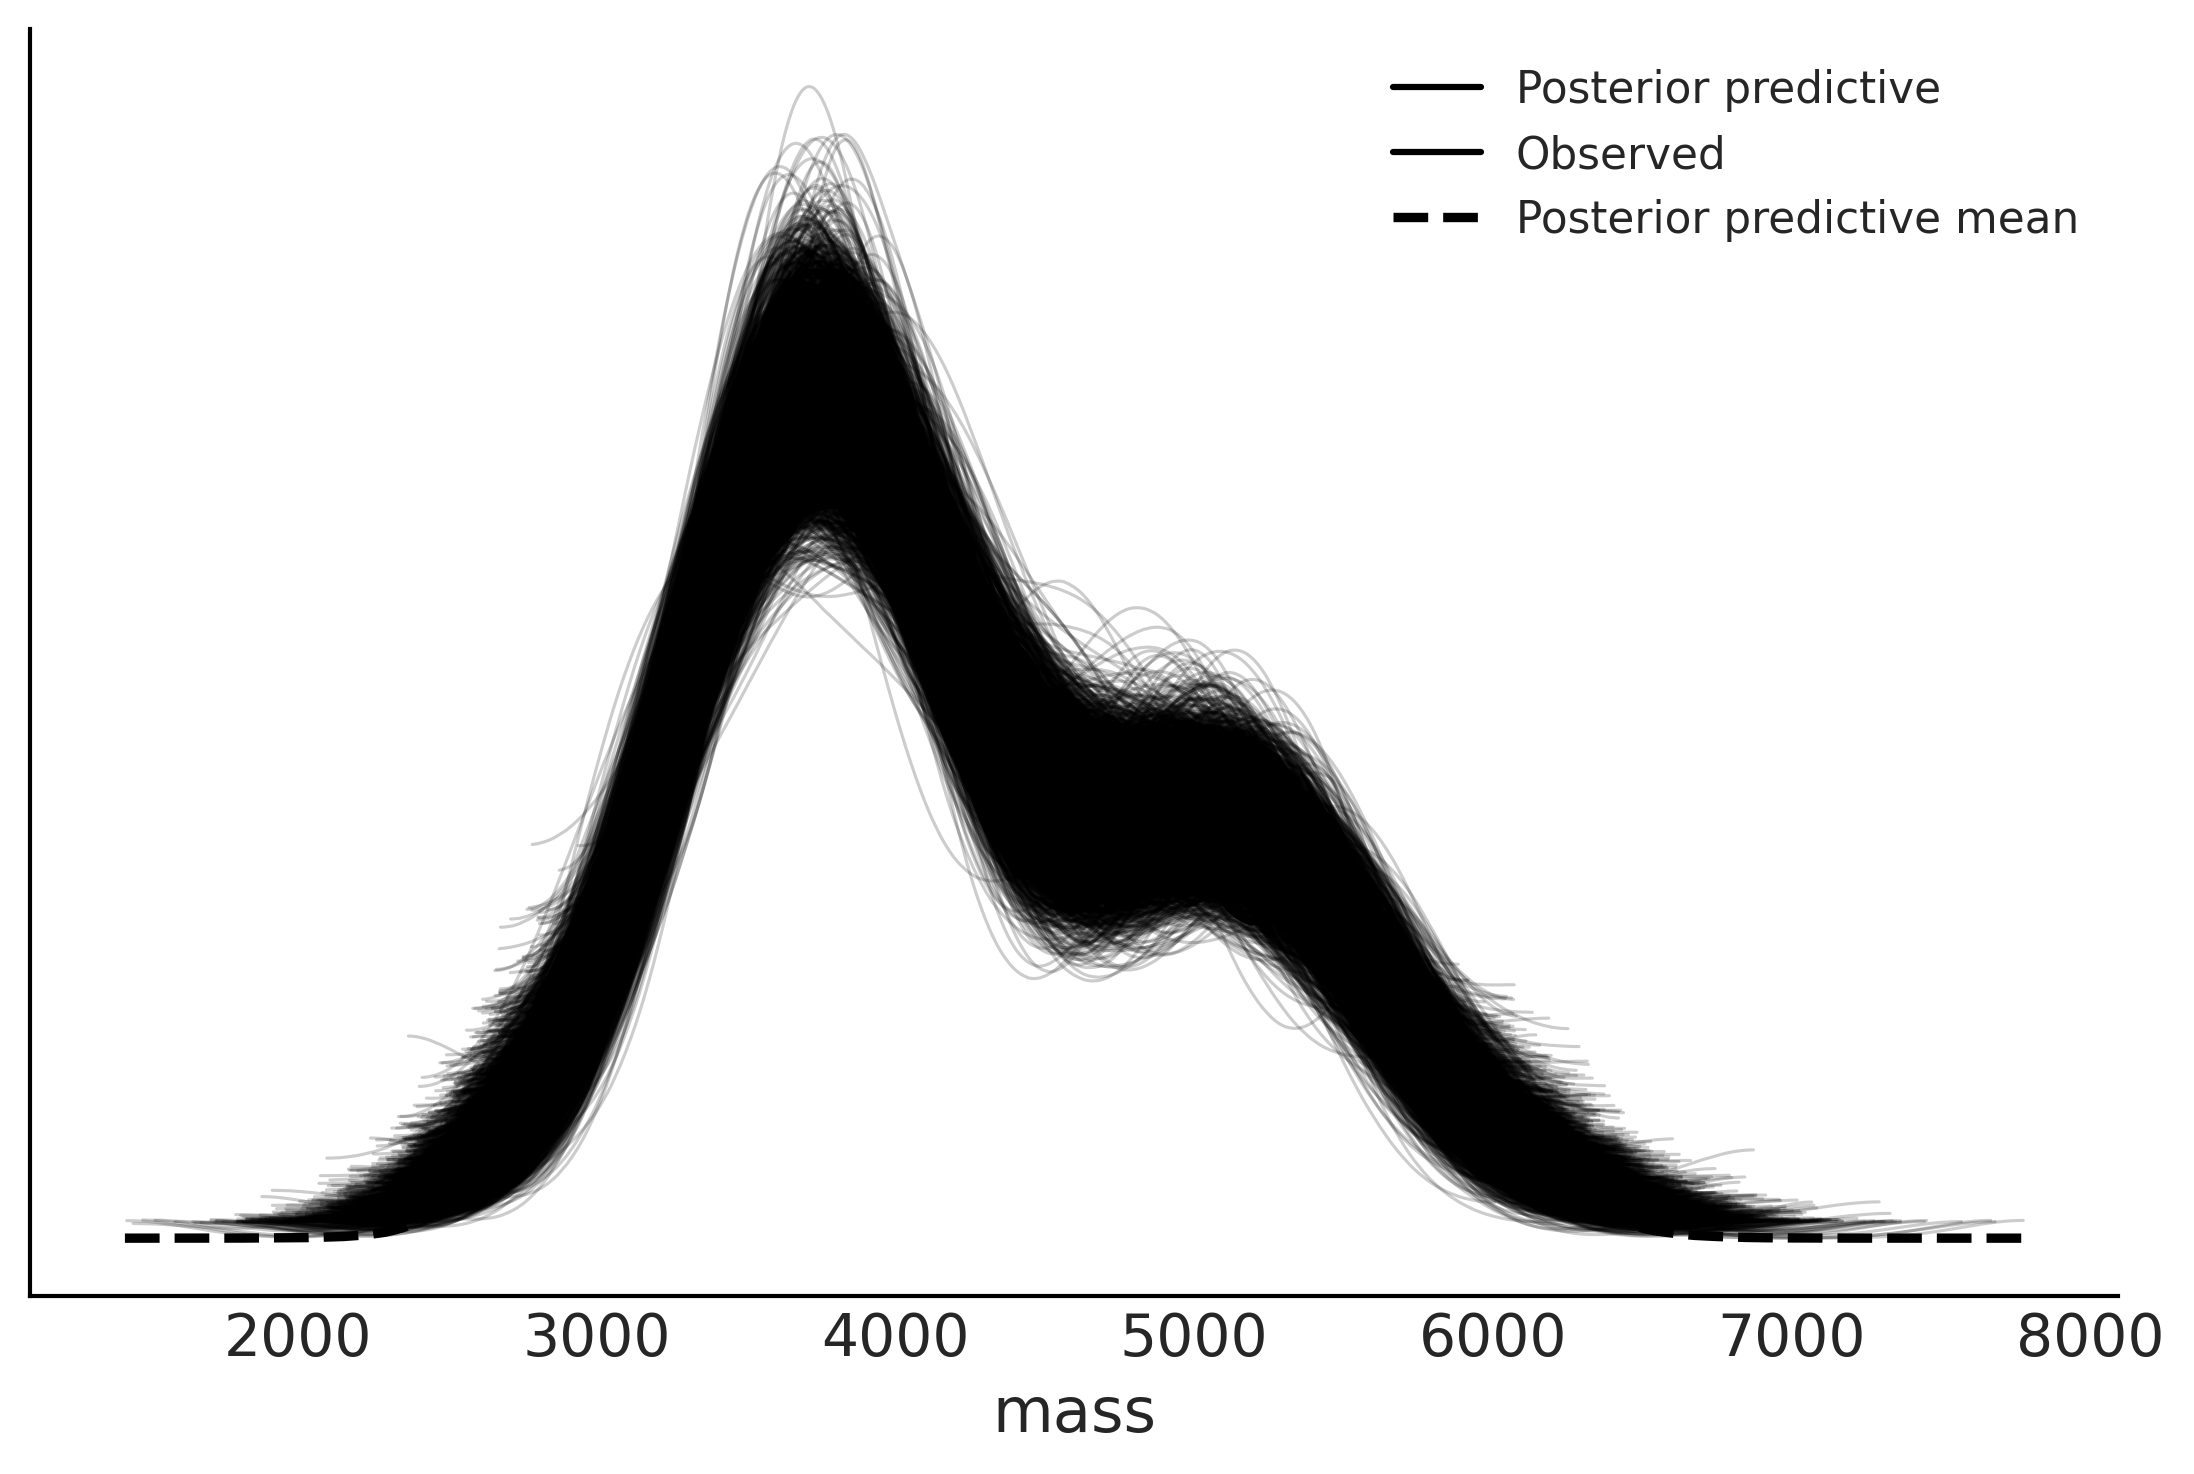

In [29]:
az.plot_ppc(inf_data_model_penguin_mass_all_species2)

In [30]:
az.loo(inf_data_model_penguin_mass_all_species2)

Computed from 4000 by 333 log-likelihood matrix

         Estimate       SE
elpd_loo -2516.19    11.60
p_loo        5.48        -

## Linear Regression

/var/folders/nf/ch8x562s5q30j7qbf07161qr0000gp/T/ipykernel_42739/1971144871.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")
/var/folders/nf/ch8x562s5q30j7qbf07161qr0000gp/T/ipykernel_42739/1971144871.py:41: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig("img/3d_linear_regression.png", bbox_inches="tight", dpi=300)
/Users/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure large

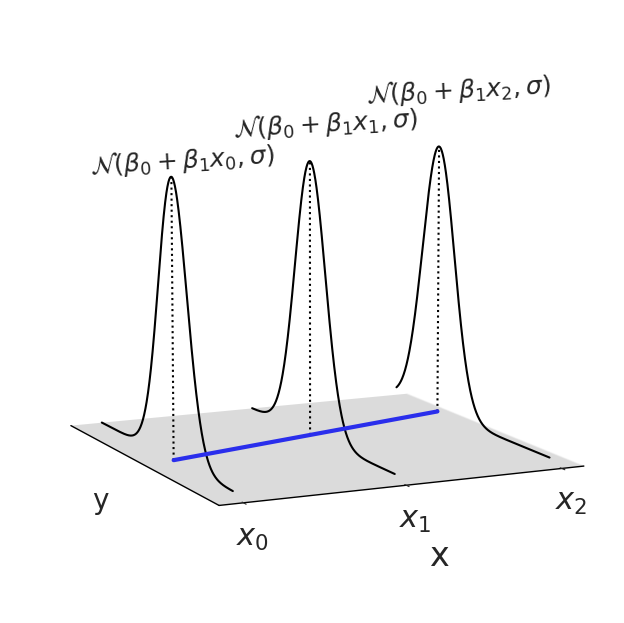

In [31]:
az.style.use("arviz-grayscale")

fig = plt.figure(figsize=(10, 8))
ax = fig.gca(projection="3d")

x = np.linspace(-16, 12, 500)
z = np.array([0, 4, 8])

for i, zi in enumerate(z):
    dens = stats.norm(-zi, 3).pdf(x)
    ax.plot(x, dens, zs=zi + 1, zdir="y", c="k")
    ax.plot([-zi, -zi], [0, max(dens)], zs=zi + 1, c="k", ls=":", zdir="y")
    ax.text(
        -zi,
        zi - 1,
        max(dens) * 1.03 + i / 100,
        f"$\\mathcal{{N}}(\\beta_0 + \\beta_1 x_{i}, \\sigma)$",
        zdir="y",
        fontsize=18,
    )

ax.plot(-z, z + 1, "C4-", lw=3)


ax.set_xlabel("y", fontsize=20)
ax.set_ylabel("x", fontsize=24, labelpad=20)

ax.set_yticks([zi + 1 for zi in z])
ax.set_yticklabels([f"$x_{i}$" for i in range(len(z))], fontsize=22)
ax.grid(False)
ax.set_xticks([])
ax.set_zticks([])
ax.yaxis.pane.fill = False
ax.xaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor("None")
ax.yaxis.pane.set_edgecolor("None")
ax.zaxis.pane.set_facecolor("C3")
ax.w_zaxis.line.set_linewidth(0)
ax.view_init(elev=10, azim=-25)
# plt.savefig("img/3d_linear_regression.png", bbox_inches="tight", dpi=300)
plt.savefig("img/chp03/3d_linear_regression.png", bbox_inches="tight", dpi=300)

In [32]:
adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"].values
adelie_flipper_length_shared = tt.shared(adelie_flipper_length_obs)

with pm.Model() as model_adelie_flipper_regression:
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_1 = pm.Normal("β_1", 0, 4000)
    β_0 = pm.Normal("β_0", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1*adelie_flipper_length_shared)
    
    mass = pm.Normal("mass", mu=μ, sd=σ, observed = adelie_mass_obs)
    
    # Need to remove this one I find bug
    inf_data_adelie_flipper_regression = pm.sample(return_inferencedata=True, random_seed=0)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_0, β_1, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


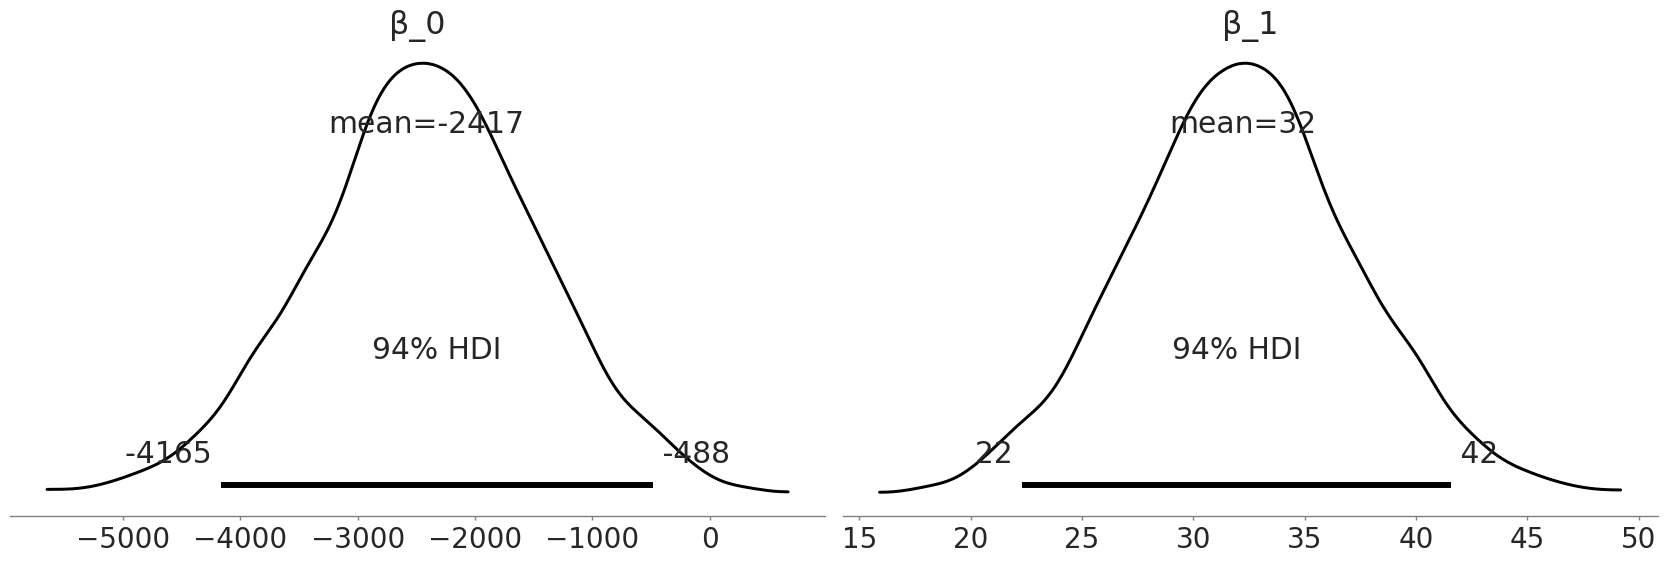

In [33]:
axes = az.plot_posterior(inf_data_adelie_flipper_regression, var_names = ["β_0", "β_1"], textsize=20);

#plot_label_resizer(axes, fontsize)
plt.savefig("img/chp03/adelie_coefficient_posterior_plots")

In [34]:
inf_data_adelie_flipper_regression.posterior.mean().to_dict()["data_vars"]["β_1"]["data"]

32.21572584887332

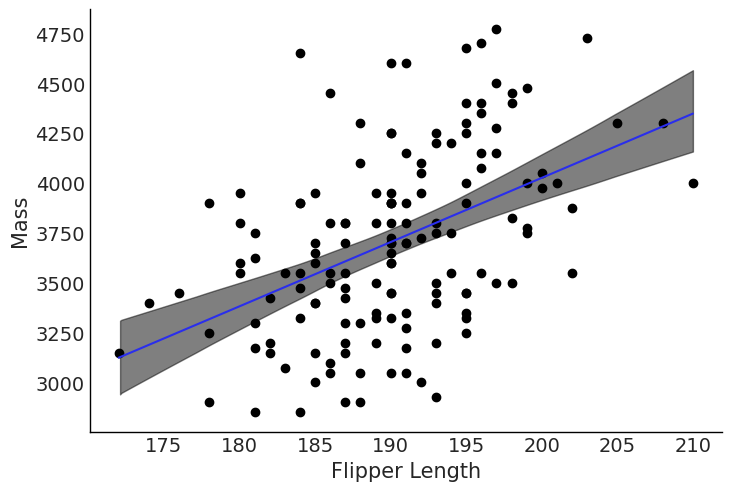

In [35]:
fig, ax = plt.subplots()
alpha_m = inf_data_adelie_flipper_regression.posterior.mean().to_dict()["data_vars"]["β_0"]["data"]
beta_m = inf_data_adelie_flipper_regression.posterior.mean().to_dict()["data_vars"]["β_1"]["data"]

flipper_length = np.linspace(adelie_flipper_length_obs.min(), adelie_flipper_length_obs.max(), 100)

flipper_length_mean = alpha_m + beta_m * flipper_length
ax.plot(flipper_length, flipper_length_mean, c='C4',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

ax.scatter(adelie_flipper_length_obs, adelie_mass_obs)

# Figure out how to do this from inference data
az.plot_hdi(adelie_flipper_length_obs, inf_data_adelie_flipper_regression.posterior['μ'], hdi_prob=0.94, color='k', ax=ax)

ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass');
plt.savefig('img/chp03/flipper_length_mass_regression.png', dpi=300)

### Make a Prediction

In [36]:
adelie_flipper_length_shared.set_value([adelie_flipper_length_obs.mean()])

with model_adelie_flipper_regression:
    posterior_predictions = pm.sample_posterior_predictive(
        inf_data_adelie_flipper_regression.posterior, var_names=["mass", "μ"])

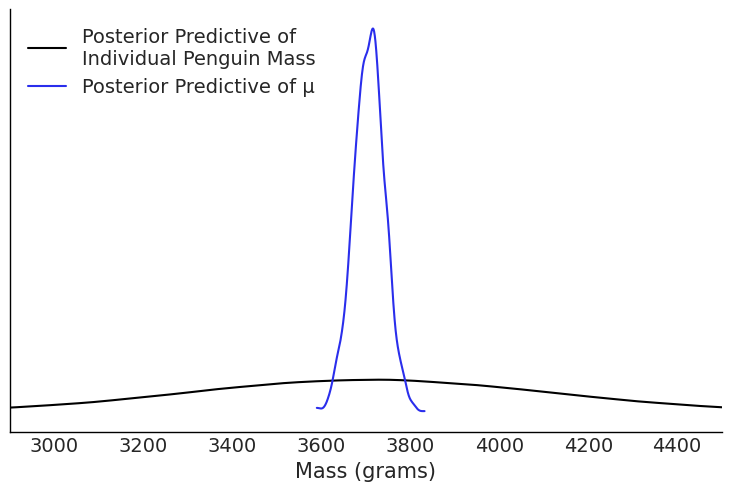

In [37]:
fig, ax = plt.subplots()
az.plot_dist(posterior_predictions["mass"], label="Posterior Predictive of \nIndividual Penguin Mass", ax=ax)
az.plot_dist(posterior_predictions["μ"],label="Posterior Predictive of μ", color="C4", ax=ax)
ax.set_xlim(2900, 4500);
ax.legend(loc=2)
ax.set_xlabel("Mass (grams)")
ax.set_yticks([])
plt.savefig('img/chp03/flipper_length_mass_posterior_predictive.png', dpi=300)

### Transformation centering (PyMC3)

In [38]:
adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"].values
adelie_flipper_length_c = adelie_flipper_length_obs - adelie_flipper_length_obs.mean()

with pm.Model() as model_adelie_flipper_regression:
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_1 = pm.Normal("β_1", 0, 4000)
    β_0 = pm.Normal("β_0", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1*adelie_flipper_length_c)
    
    mass = pm.Normal("mass", mu=μ, sd=σ, observed = adelie_mass_obs)
    
    # Need to remove this one I find bug
    inf_data_adelie_flipper_length_c = pm.sample(return_inferencedata=True, random_seed=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_0, β_1, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


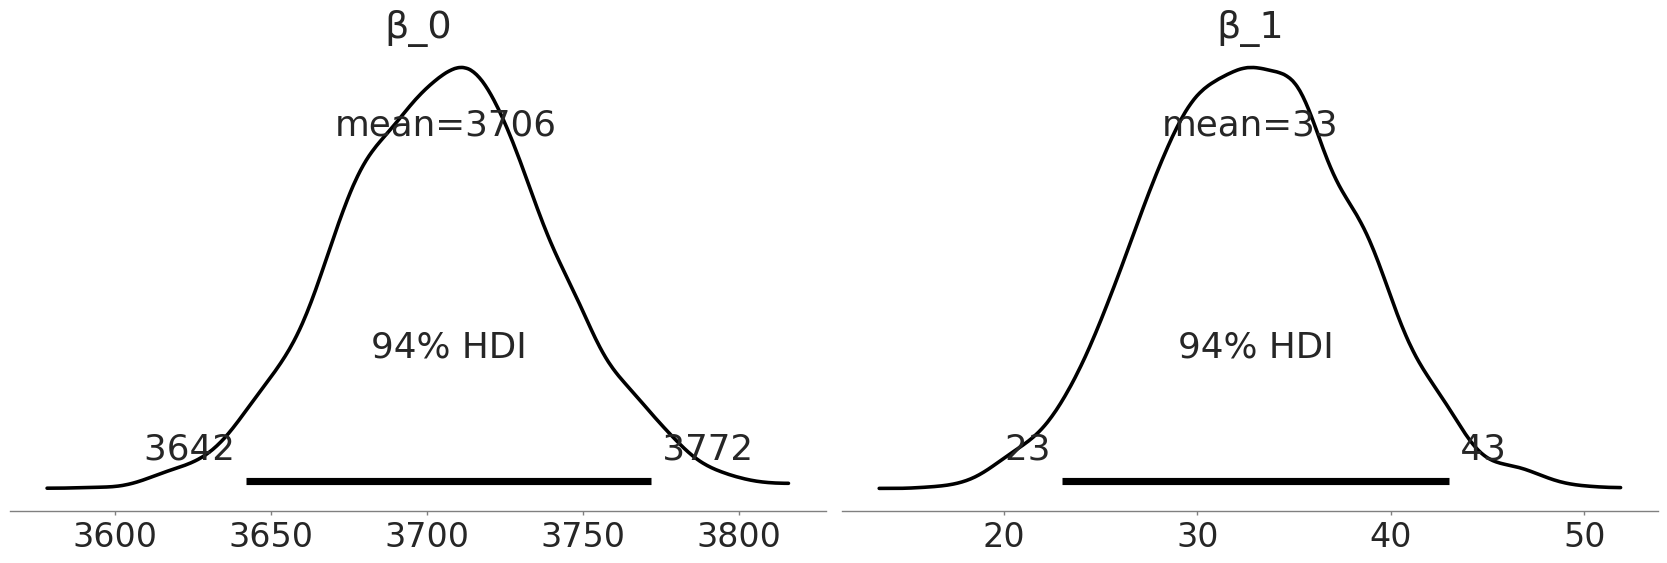

In [39]:
az.plot_posterior(inf_data_adelie_flipper_length_c, var_names = ["β_0", "β_1"], textsize=24);
plt.savefig("img/chp03/singlespecies_multipleregression_centered.png")

### Transformation centering (TFP)

In [40]:
# @title TFP `run_mcmc` (a NUTS sampling routine with simple tuning)
from tensorflow_probability.python.internal import unnest
from tensorflow_probability.python.internal import samplers


def run_mcmc(n_draws,
             joint_dist,
             n_chains=4,
             num_adaptation_steps=1000,
             return_compiled_function=False,
             bijector=None,
             init_state=None,
             seed=None,
             **pins):
    joint_dist_pinned = joint_dist.experimental_pin(**pins)
    if bijector is None:
        bijector = joint_dist_pinned.experimental_default_event_space_bijector()
    target_log_prob_fn = joint_dist_pinned.unnormalized_log_prob

    if seed is None:
        seed = 26401
    run_mcmc_seed = samplers.sanitize_seed(seed, salt='run_mcmc_seed')

    if init_state is None:
        init_state_ = joint_dist_pinned.sample_unpinned(n_chains)
        ini_state_unbound = bijector.inverse(init_state_)
        run_mcmc_seed, *init_seed = samplers.split_seed(
            run_mcmc_seed, n=len(ini_state_unbound)+1)
        init_state = bijector.forward(
            tf.nest.map_structure(
                lambda x, seed: tfd.Uniform(-1., tf.constant(1., x.dtype)).sample(
                    x.shape, seed=seed),
                ini_state_unbound,
                tf.nest.pack_sequence_as(ini_state_unbound, init_seed)))

    @tf.function(autograph=False, jit_compile=True)
    def run_inference_nuts(init_state, draws, tune, seed):
        seed, tuning_seed, sample_seed = samplers.split_seed(seed, n=3)

        def gen_kernel(step_size):
            hmc = tfp.mcmc.NoUTurnSampler(
                target_log_prob_fn=target_log_prob_fn, step_size=step_size)
            hmc = tfp.mcmc.TransformedTransitionKernel(
                hmc, bijector=bijector)
            tuning_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
                hmc, tune // 2, target_accept_prob=0.85)
            return tuning_hmc

        def tuning_trace_fn(_, pkr):
            return pkr.inner_results.transformed_state, pkr.new_step_size

        def get_tuned_stepsize(samples, step_size):
            return tf.math.reduce_std(samples, axis=0) * step_size[-1]

        step_size = tf.nest.map_structure(
            tf.ones_like, bijector.inverse(init_state))
        tuning_hmc = gen_kernel(step_size)
        init_samples, (sample_unbounded, tuning_step_size) = tfp.mcmc.sample_chain(
            num_results=200,
            num_burnin_steps=tune // 2 - 200,
            current_state=init_state,
            kernel=tuning_hmc,
            trace_fn=tuning_trace_fn,
            seed=tuning_seed)

        tuning_step_size = tf.nest.pack_sequence_as(
            sample_unbounded, tuning_step_size)
        step_size_new = tf.nest.map_structure(get_tuned_stepsize,
                                              sample_unbounded,
                                              tuning_step_size)
        sample_hmc = gen_kernel(step_size_new)

        def sample_trace_fn(_, pkr):
            # Using PyMC3 naming convention
            return {
                'lp': unnest.get_innermost(pkr, 'target_log_prob'),
                'tree_size': unnest.get_innermost(pkr, 'leapfrogs_taken'),
                'diverging': unnest.get_innermost(pkr, 'has_divergence'),
                'energy': unnest.get_innermost(pkr, 'energy'),
                'mean_tree_accept': unnest.get_innermost(pkr, 'log_accept_ratio'),
                'reach_max_depth': unnest.get_innermost(pkr, 'reach_max_depth'),
            }
        current_state = tf.nest.map_structure(lambda x: x[-1], init_samples)
        return tfp.mcmc.sample_chain(
            num_results=draws,
            num_burnin_steps=tune // 2,
            current_state=current_state,
            kernel=sample_hmc,
            trace_fn=sample_trace_fn,
            seed=sample_seed)

    mcmc_samples, mcmc_diagnostic = run_inference_nuts(
        init_state, n_draws, num_adaptation_steps, run_mcmc_seed)

    if return_compiled_function:
        return mcmc_samples, mcmc_diagnostic, run_inference_nuts
    else:
        return mcmc_samples, mcmc_diagnostic

In [41]:
def gen_adelie_flipper_model(adelie_flipper_length):
    adelie_flipper_length = tf.constant(adelie_flipper_length, tf.float32)

    @tfd.JointDistributionCoroutine
    def jd_adelie_flipper_regression():
        σ = yield root(tfd.HalfStudentT(df=100, loc=0, scale=2000, name='sigma'))
        β_1 = yield root(tfd.Normal(loc=0, scale=4000, name='beta_1'))
        β_0 = yield root(tfd.Normal(loc=0, scale=4000, name='beta_0'))
        μ = β_0[..., None] + β_1[..., None] * adelie_flipper_length
        mass = yield tfd.Independent(
            tfd.Normal(loc=μ, scale=σ[..., None]),
            reinterpreted_batch_ndims=1,
            name='mass')

    return jd_adelie_flipper_regression


# Use non-centered predictor, this gives the same model as
# model_adelie_flipper_regression
jd_adelie_flipper_regression = gen_adelie_flipper_model(
    adelie_flipper_length_obs)

# Use centered predictor
jd_adelie_flipper_regression = gen_adelie_flipper_model(
    adelie_flipper_length_c)

mcmc_samples, sampler_stats = run_mcmc(
    1000, jd_adelie_flipper_regression, n_chains=4, num_adaptation_steps=1000,
    mass=tf.constant(adelie_mass_obs, tf.float32))

inf_data_adelie_flipper_length_c = az.from_dict(
    posterior={
        k:np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in sampler_stats.keys()
#         ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    }
)

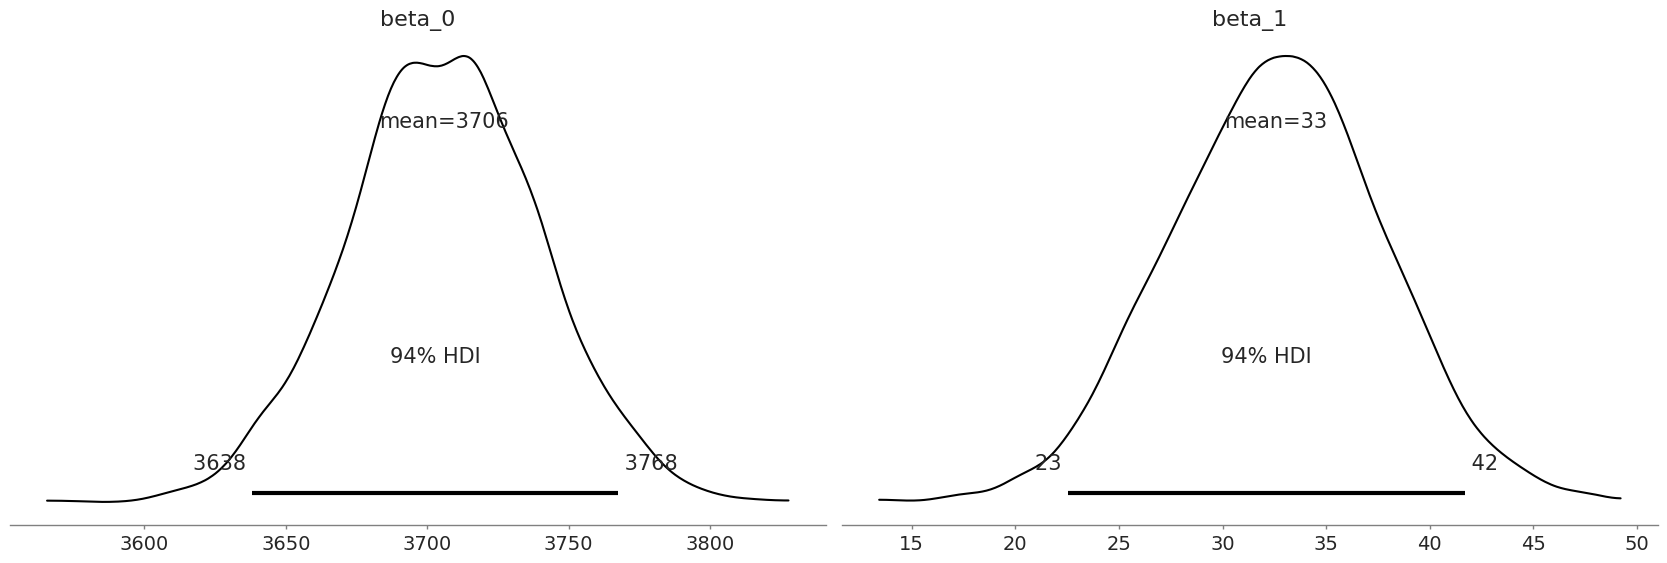

In [42]:
az.plot_posterior(inf_data_adelie_flipper_length_c, var_names = ["beta_0", "beta_1"]);

## Multiple Linear regression

### Additional Categorical factor of Sex

In [43]:
sex_obs = penguins.loc[adelie_mask ,"sex"].replace({"male":0, "female":1})

with pm.Model() as model_penguin_mass_categorical:
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 3000)
    β_1 = pm.Normal("β_1", 0, 3000)
    β_2 = pm.Normal("β_2", 0, 3000)
    
    μ = pm.Deterministic("μ", β_0 + β_1*adelie_flipper_length_obs + β_2*sex_obs)
    
    
    mass = pm.Normal("mass", mu=μ, sd=σ, observed = adelie_mass_obs)
    
    inf_data_penguin_mass_categorical = pm.sample(target_accept=.9, random_seed=0, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_2, β_1, β_0, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


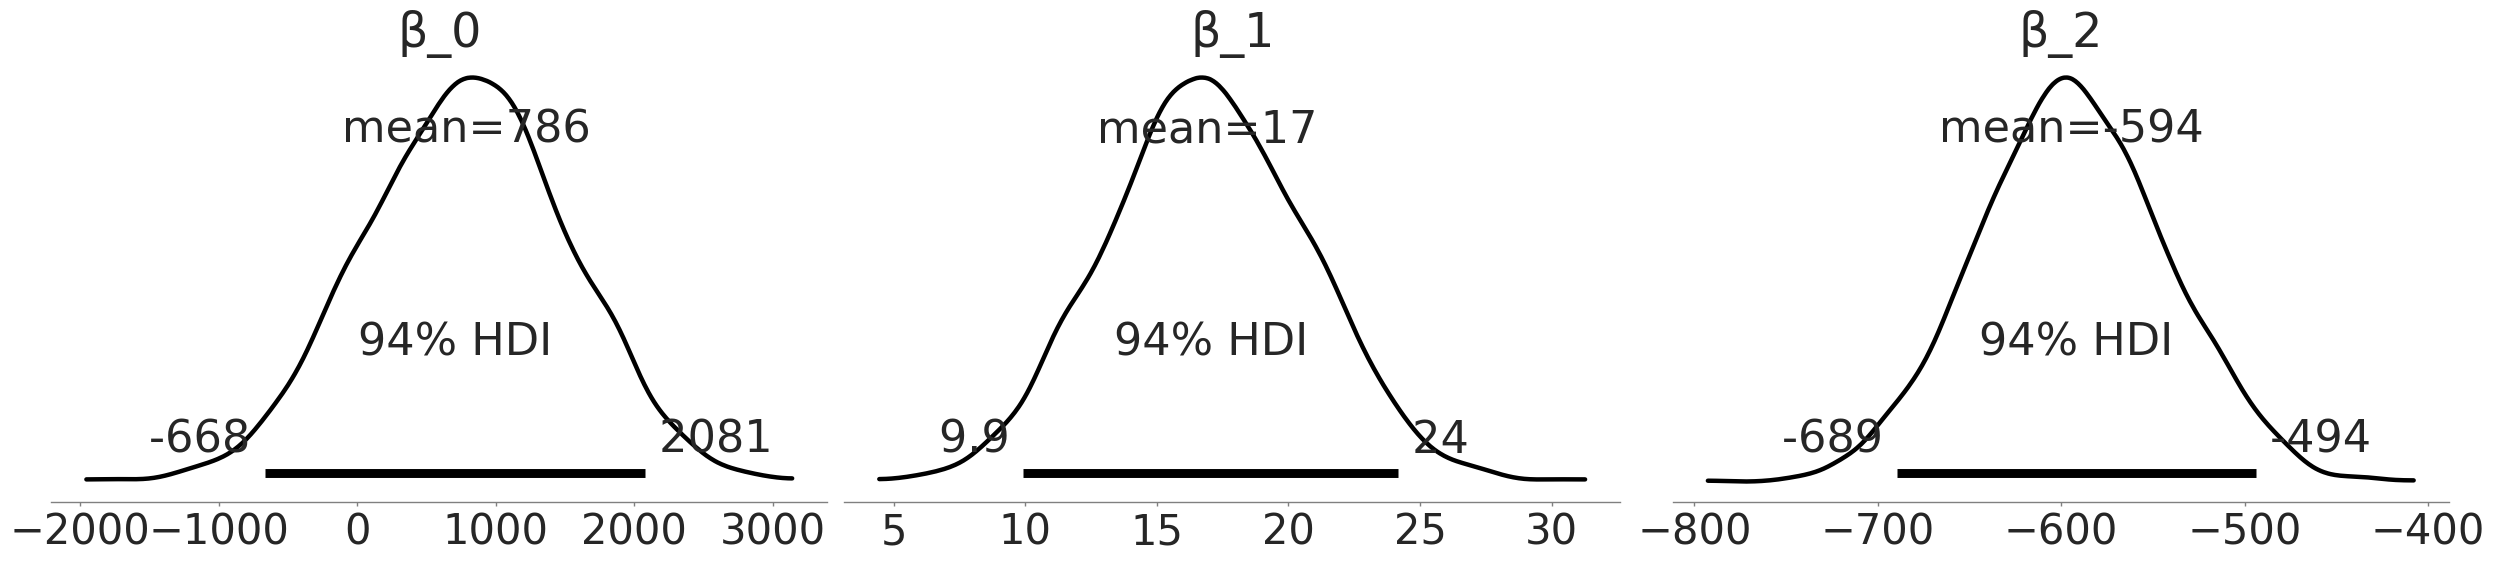

In [102]:
az.plot_posterior(inf_data_penguin_mass_categorical, var_names =["β_0", "β_1", "β_2"], textsize=30)
plt.savefig("img/chp03/adelie_sex_coefficient_posterior.png")

#### Vertical Posterior Layout

In [46]:
az.summary(inf_data_penguin_mass_categorical, var_names=["β_0","β_1","β_2", "σ"])

mean       sd   hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
β_0  785.644  741.681 -667.955  2081.214     19.715   13.943    1415.0   
β_1   16.926    3.849    9.932    24.174      0.102    0.073    1425.0   
β_2 -594.450   51.792 -689.383  -494.006      1.116    0.790    2155.0   
σ    297.693   18.342  264.109   332.982      0.351    0.249    2722.0   

     ess_tail  r_hat  
β_0    1705.0    1.0  
β_1    1668.0    1.0  
β_2    2100.0    1.0  
σ      2174.0    1.0

Looking at the uncertainty in measurement again we see that adding sex reduces our standard deviation estimate even more. Inuitively this also makes sense.

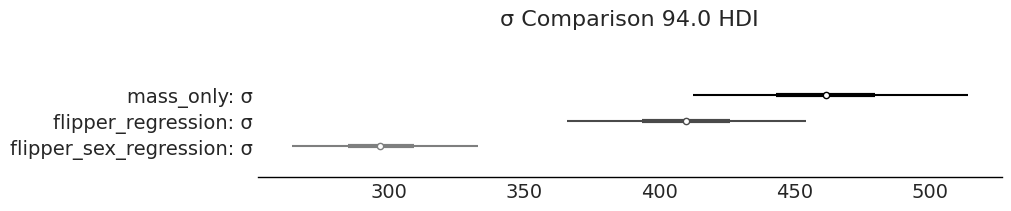

In [47]:
axes = az.plot_forest([inf_data_adelie_penguin_mass, inf_data_adelie_flipper_regression, inf_data_penguin_mass_categorical],
               var_names=["σ"], combined=True, model_names=["mass_only", "flipper_regression", "flipper_sex_regression"], figsize=(10,2))
axes[0].set_title("σ Comparison 94.0 HDI")
plt.savefig("img/chp03/singlespecies_multipleregression_forest_sigma_comparison.png")

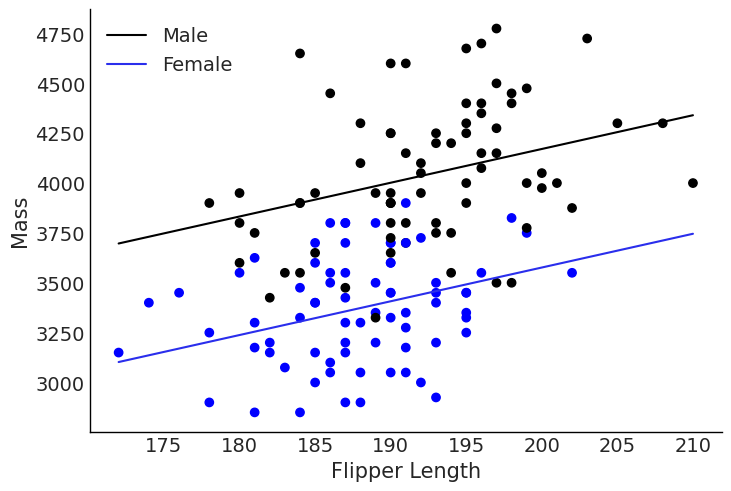

In [48]:
# Fix colors
fig, ax = plt.subplots()
alpha_1 = inf_data_penguin_mass_categorical.posterior.mean().to_dict()["data_vars"]["β_0"]["data"]
beta_1 = inf_data_penguin_mass_categorical.posterior.mean().to_dict()["data_vars"]["β_1"]["data"]
beta_2 = inf_data_penguin_mass_categorical.posterior.mean().to_dict()["data_vars"]["β_2"]["data"]


flipper_length = np.linspace(adelie_flipper_length_obs.min(), adelie_flipper_length_obs.max(), 100)

mass_mean_male = alpha_1 + beta_1 * flipper_length
mass_mean_female = alpha_1 + beta_1 * flipper_length + beta_2

ax.plot(flipper_length, mass_mean_male,
         label="Male")

ax.plot(flipper_length, mass_mean_female, c='C4',
         label="Female")

ax.scatter(adelie_flipper_length_obs, adelie_mass_obs, c=[{0:"k", 1:"b"}[code] for code in sex_obs.values])

# Figure out how to do this from inference data
#az.plot_hpd(adelie_flipper_length, trace.get_values(varname="μ"), credible_interval=0.94, color='k', ax=ax)

ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass');
ax.legend()
plt.savefig("img/chp03/single_species_categorical_regression.png")

In [49]:
def gen_jd_flipper_bill_sex(flipper_length, sex, bill_length):
    flipper_length, sex, bill_length = tf.nest.map_structure(
        lambda x: tf.constant(x, tf.float32), 
        (flipper_length, sex, bill_length)
    )

    @tfd.JointDistributionCoroutine
    def jd_flipper_bill_sex():
        σ = yield root(tfd.HalfStudentT(df=100, loc=0, scale=2000, name='sigma'))
        β_0 = yield root(tfd.Normal(loc=0, scale=3000, name='beta_0'))
        β_1 = yield root(tfd.Normal(loc=0, scale=3000, name='beta_1'))
        β_2 = yield root(tfd.Normal(loc=0, scale=3000, name='beta_2'))
        β_3 = yield root(tfd.Normal(loc=0, scale=3000, name='beta_3'))
        μ = (β_0[..., None] 
             + β_1[..., None] * flipper_length 
             + β_2[..., None] * sex
             + β_3[..., None] * bill_length
            )
        mass = yield tfd.Independent(
            tfd.Normal(loc=μ, scale=σ[..., None]),
            reinterpreted_batch_ndims=1,
            name='mass')

    return jd_flipper_bill_sex

bill_length_obs = penguins.loc[adelie_mask, "bill_length_mm"]
jd_flipper_bill_sex = gen_jd_flipper_bill_sex(
    adelie_flipper_length_obs, sex_obs, bill_length_obs)

mcmc_samples, sampler_stats = run_mcmc(
    1000, jd_flipper_bill_sex, n_chains=4, num_adaptation_steps=1000,
    mass=tf.constant(adelie_mass_obs, tf.float32))

In [50]:
inf_data_model_penguin_flipper_bill_sex = az.from_dict(
    posterior={
        k:np.swapaxes(v, 1, 0)
        for k, v in mcmc_samples._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in sampler_stats.keys()}
)

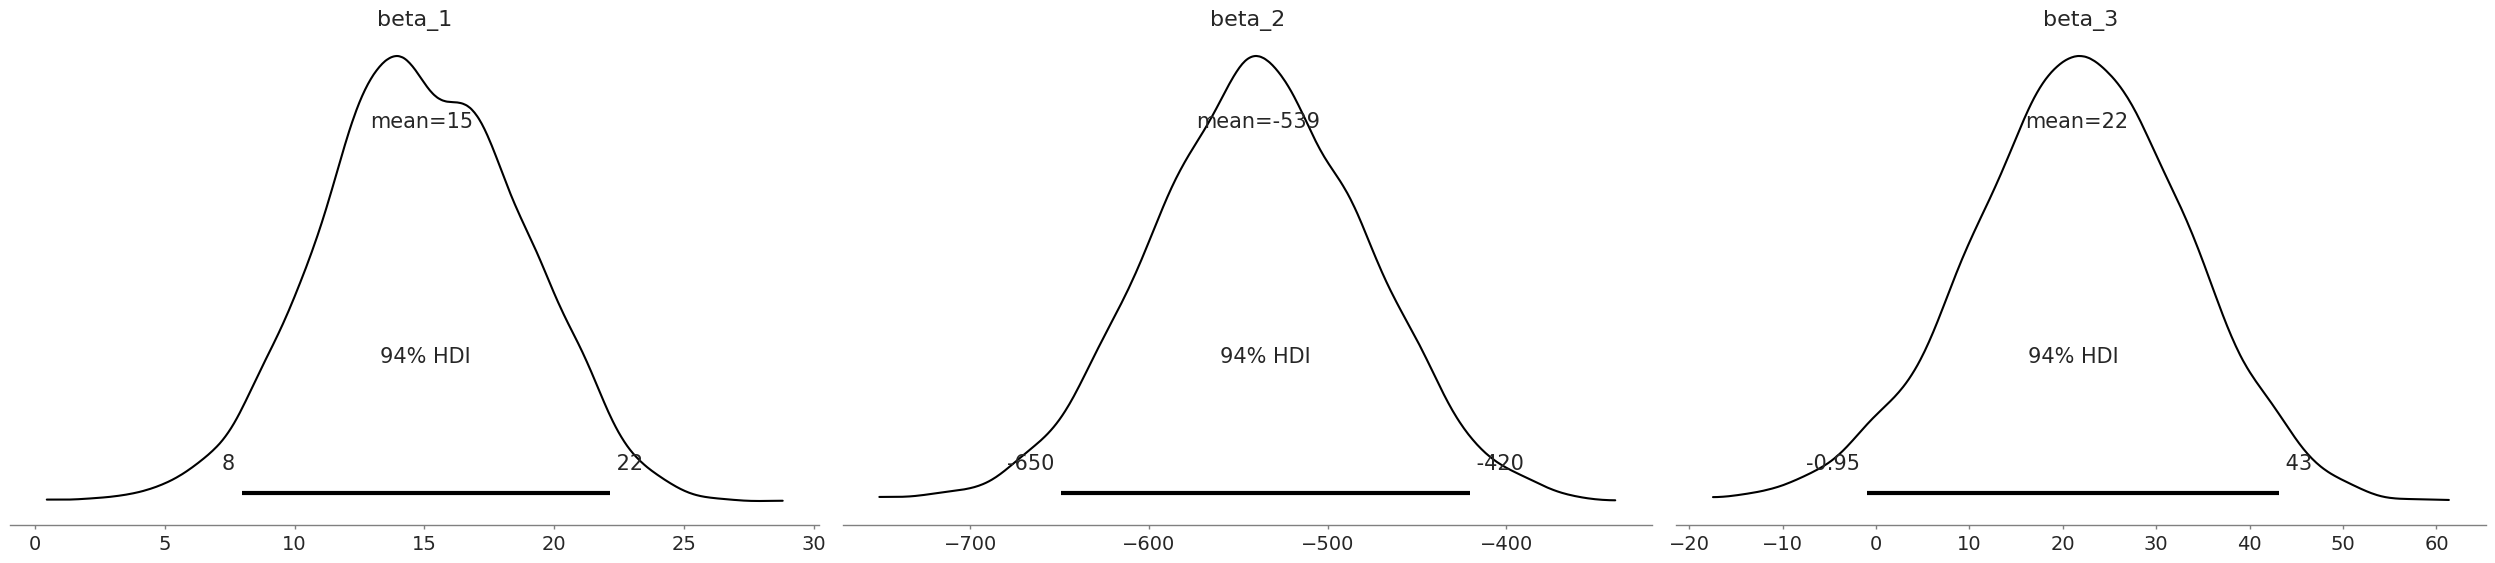

In [51]:
az.plot_posterior(inf_data_model_penguin_flipper_bill_sex, var_names=["beta_1", "beta_2", "beta_3"]);

In [52]:
az.summary(inf_data_model_penguin_flipper_bill_sex, var_names=["beta_1", "beta_2", "beta_3", "sigma"])

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_1   14.877   3.885    7.961   22.135      0.135    0.095     831.0   
beta_2 -539.139  61.259 -649.514 -420.372      1.478    1.068    1739.0   
beta_3   21.537  11.678   -0.949   43.182      0.282    0.199    1747.0   
sigma   295.156  17.536  265.024  329.920      0.302    0.214    3386.0   

        ess_tail  r_hat  
beta_1    1387.0    1.0  
beta_2    1498.0    1.0  
beta_3    1855.0    1.0  
sigma     2597.0    1.0

#### Mass Counterfactual

In [53]:
mean_flipper_length = penguins.loc[adelie_mask, "flipper_length_mm"].mean()
# Counterfactual dimensions is set to 21 to allow us to get the mean exactly
counterfactual_flipper_lengths = np.linspace(
    mean_flipper_length-20, mean_flipper_length+20, 21)
sex_male_indicator = np.zeros_like(counterfactual_flipper_lengths)
mean_bill_length = np.ones_like(
    counterfactual_flipper_lengths) * bill_length_obs.mean()

jd_flipper_bill_sex_counterfactual = gen_jd_flipper_bill_sex(
    counterfactual_flipper_lengths, sex_male_indicator, mean_bill_length)
ppc_samples = jd_flipper_bill_sex_counterfactual.sample(value=mcmc_samples)
estimated_mass = ppc_samples[-1].numpy().reshape(-1, 21)

/Users/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


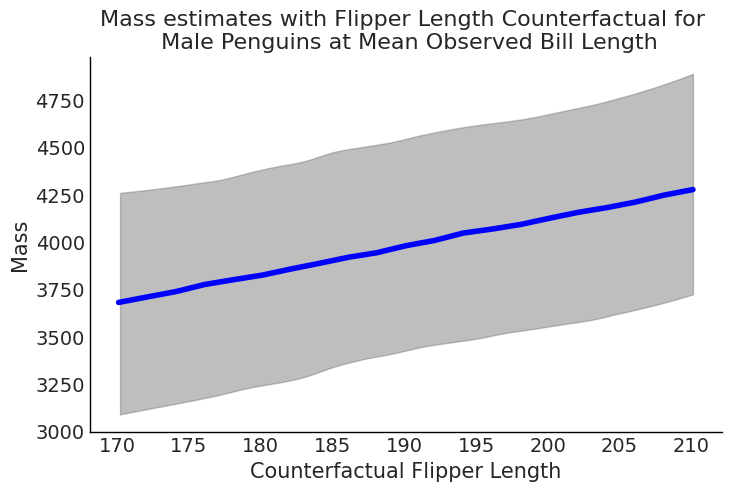

In [54]:
az.plot_hdi(counterfactual_flipper_lengths, estimated_mass, color="C2", plot_kwargs={"ls": "--"})
plt.plot(counterfactual_flipper_lengths, estimated_mass.mean(axis=0), lw=4, c="blue")
plt.title("Mass estimates with Flipper Length Counterfactual for \n Male Penguins at Mean Observed Bill Length")
plt.xlabel("Counterfactual Flipper Length")
plt.ylabel("Mass")
plt.savefig("img/chp03/linear_counter_factual.png")

### Multiple Linear Regression PyMC3

In [55]:
sex_obs_shared = tt.shared(penguins.loc[adelie_mask ,"sex"].replace({"male":0, "female":1}).values)
bill_length_obs_shared = tt.shared(penguins.loc[adelie_mask, "bill_length_mm"].values)
adelie_flipper_length_obs = tt.shared(penguins.loc[adelie_mask, "flipper_length_mm"].values)

with pm.Model() as model_penguin_mass_categorical:
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 3000)
    β_1 = pm.Normal("β_1", 0, 3000)
    β_2 = pm.Normal("β_2", 0, 3000)
    β_3 = pm.Normal("β_3", 0, 3000)

    μ = pm.Deterministic("μ", β_0 + β_1*adelie_flipper_length_obs + β_2*sex_obs_shared + β_3*bill_length_obs_shared)
        
    mass = pm.Normal("mass", mu=μ, sd=σ, observed = adelie_mass_obs)
    
    trace_penguin_mass_categorical = pm.sample(target_accept=.9, random_seed=0)

/var/folders/nf/ch8x562s5q30j7qbf07161qr0000gp/T/ipykernel_42739/3896076514.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_penguin_mass_categorical = pm.sample(target_accept=.9, random_seed=0)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_3, β_2, β_1, β_0, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


#### Mass Counterfactual
Holding bill length and sex at fixed value and varying flipper length

In [56]:
n_obs = sum(adelie_mask)
sex_obs_shared.set_value(np.repeat(0, n_obs))
bill_length_obs_shared.set_value(np.repeat(penguins.loc[adelie_mask, "bill_length_mm"].mean(), n_obs))
counter_factual_flipper_lengths = np.linspace(mean_flipper_length-20, mean_flipper_length+20, n_obs)
adelie_flipper_length_obs.set_value(np.linspace(mean_flipper_length-20, mean_flipper_length+20, n_obs))


with model_penguin_mass_categorical:
    ppc = pm.sample_posterior_predictive(inf_data_penguin_mass_categorical, var_names=["mass","μ"])

/Users/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


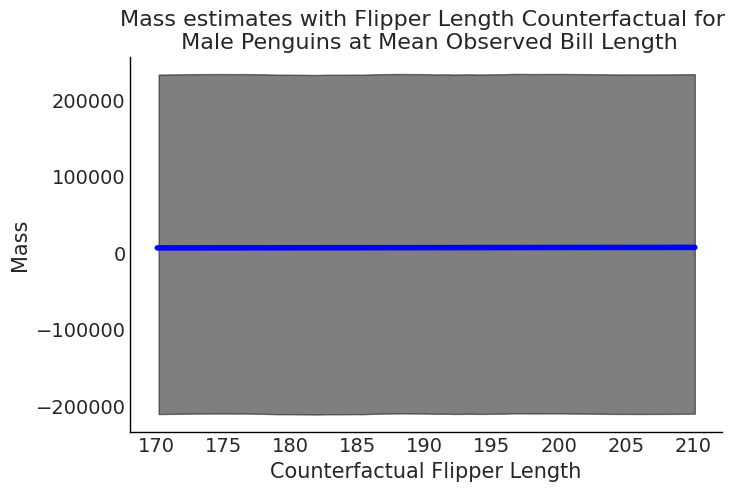

In [59]:
az.plot_hdi(counter_factual_flipper_lengths, ppc["mass"], color="k", plot_kwargs={"ls": "--"})
plt.plot(counter_factual_flipper_lengths, ppc["mass"].mean(axis=0), lw=4, c="blue")
plt.title("Mass estimates with Flipper Length Counterfactual for \n Male Penguins at Mean Observed Bill Length")
plt.xlabel("Counterfactual Flipper Length")
plt.ylabel("Mass")
plt.savefig("img/chp03/linear_counterFactual.png")

## Logistic Function

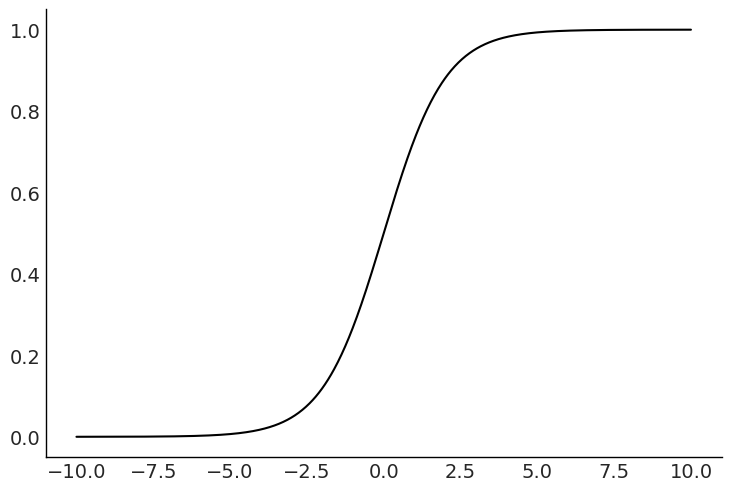

In [60]:
x = np.linspace(-10, 10, 1000)
y = special.expit(x)

plt.plot(x,y)
plt.savefig("img/chp03/logistic.png")

## Predicting penguins


### Bill Length

/var/folders/nf/ch8x562s5q30j7qbf07161qr0000gp/T/ipykernel_42739/2263122395.py:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_logistic_penguins_bill_length = pm.sample(5000, random_seed=0, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [β_1, β_0]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 29 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


<AxesSubplot:>

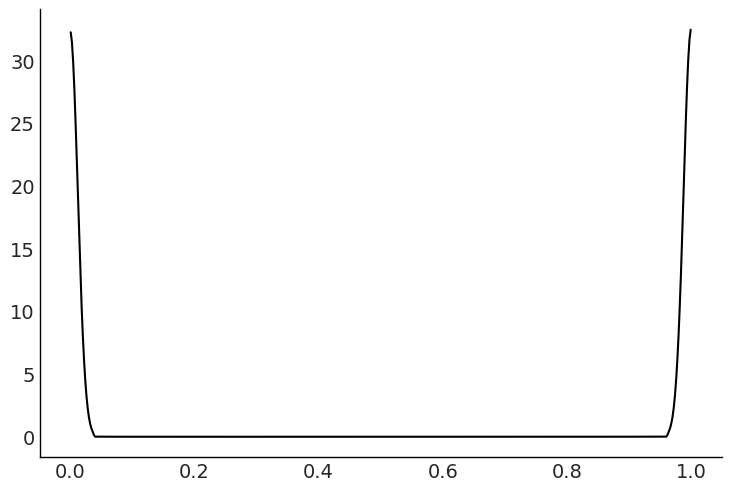

In [61]:
species_filter = penguins["species"].isin(["Adelie", "Chinstrap"])
bill_length_obs = penguins.loc[species_filter, "bill_length_mm"].values
species = pd.Categorical(penguins.loc[species_filter, "species"])


with pm.Model() as model_logistic_penguins_bill_length:
    β_0 = pm.Normal("β_0", mu=0, sd=30)
    β_1 = pm.Normal('β_1', mu=0, sd=30)
    
    μ = β_0 + pm.math.dot(bill_length_obs, β_1)  

    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -β_0/β_1)
    
    p = pm.Bernoulli('p', p=θ, observed=species.codes)
    
    prior_predictive_logistic_penguins_bill_length = pm.sample_prior_predictive(samples=10000)
    trace_logistic_penguins_bill_length = pm.sample(5000, random_seed=0, chains=2)
    posterior_predictive_logistic_penguins_bill_length = pm.sample_posterior_predictive(trace_logistic_penguins_bill_length)

    inf_data_logistic_penguins_bill_length = az.from_pymc3(prior=prior_predictive_logistic_penguins_bill_length,
                                                    trace=trace_logistic_penguins_bill_length,
                                                    posterior_predictive=posterior_predictive_logistic_penguins_bill_length)
az.plot_dist(prior_predictive_logistic_penguins_bill_length["θ"]);

In [62]:
prior_predictive_logistic_penguins_bill_length["p"]

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

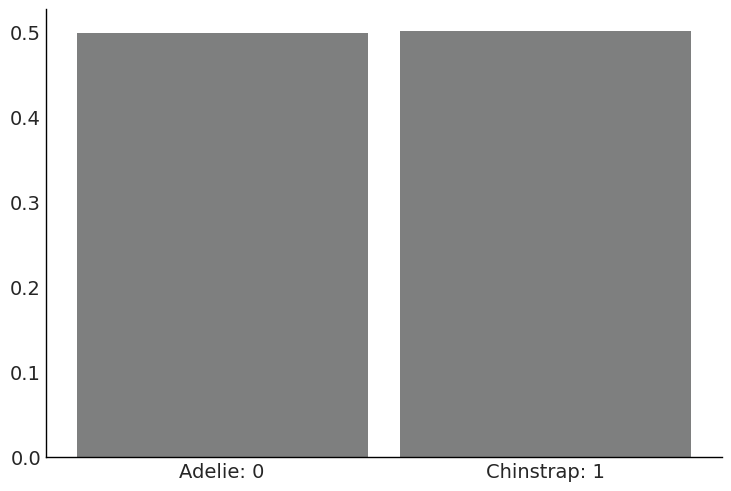

In [63]:
ax = az.plot_dist(prior_predictive_logistic_penguins_bill_length["p"], color="C2")
ax.set_xticklabels(["Adelie: 0", "Chinstrap: 1"] )
plt.savefig("img/chp03/prior_predictive_logistic.png")

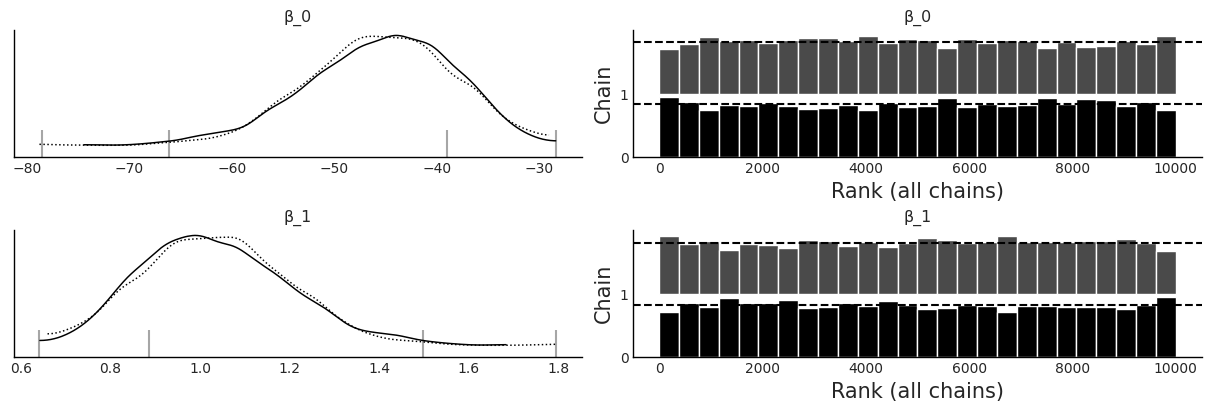

In [64]:
az.plot_trace(inf_data_logistic_penguins_bill_length, var_names=["β_0", "β_1"], kind="rank_bars");

In [65]:
az.summary(inf_data_logistic_penguins_bill_length, var_names=["β_0", "β_1", "bd"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
β_0 -45.578  7.104 -58.448  -32.498      0.189    0.134    1359.0    1049.0   
β_1   1.034  0.163   0.745    1.340      0.004    0.003    1358.0    1012.0   
bd   44.105  0.369  43.408   44.786      0.005    0.003    6617.0    7151.0   

     r_hat  
β_0    1.0  
β_1    1.0  
bd     1.0

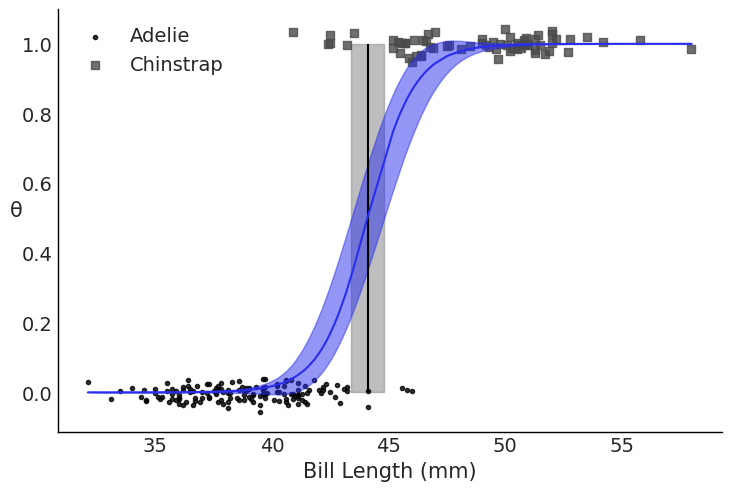

In [66]:
fig, ax = plt.subplots()

theta = inf_data_logistic_penguins_bill_length.posterior["θ"].values.reshape((-1,214)).mean(axis=0)


idx = np.argsort(bill_length_obs)

# Decision Boundary
ax.vlines(inf_data_logistic_penguins_bill_length.posterior["bd"].values.mean(), 0, 1, color='k')
bd_hpd = az.hdi(inf_data_logistic_penguins_bill_length.posterior["bd"].values.flatten(), ax=ax)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C2', alpha=0.5)


for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i)
    x = bill_length_obs[_filter]
    y = np.random.normal(i, 0.02, size=_filter.sum())
    ax.scatter(bill_length_obs[_filter], y, marker=marker, label=label, alpha=.8)

az.plot_hdi(bill_length_obs, inf_data_logistic_penguins_bill_length.posterior["θ"].values, color='C4', ax=ax, plot_kwargs={"zorder":10})
ax.plot(bill_length_obs[idx], theta[idx], color='C4', zorder=10)

ax.set_xlabel("Bill Length (mm)")
ax.set_ylabel('θ', rotation=0)
plt.legend()
plt.savefig("img/chp03/logistic_bill_length.png")

### Mass only

In [67]:
mass_obs = penguins.loc[species_filter, "body_mass_g"].values

with pm.Model() as model_logistic_penguins_mass:
    β_0 = pm.Normal('β_0', mu=0, sd=10)
    β_1 = pm.Normal('β_1', mu=0, sd=10)
    
    μ = β_0 + pm.math.dot(mass_obs, β_1)  
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -β_0/β_1)
    
    p = pm.Bernoulli('p', p=θ, observed=species.codes)

    trace_logistic_penguins_mass = pm.sample(5000, random_seed=0, target_accept=.9)
    posterior_predictive_logistic_penguins_mass = pm.sample_posterior_predictive(trace_logistic_penguins_mass)
    inf_data_logistic_penguins_mass = az.from_pymc3(trace=trace_logistic_penguins_mass,
                                                    posterior_predictive=posterior_predictive_logistic_penguins_mass)

/var/folders/nf/ch8x562s5q30j7qbf07161qr0000gp/T/ipykernel_42739/1433346048.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_logistic_penguins_mass = pm.sample(5000, random_seed=0, target_accept=.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_1, β_0]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 36 seconds.
The number of effective samples is smaller than 25% for some parameters.


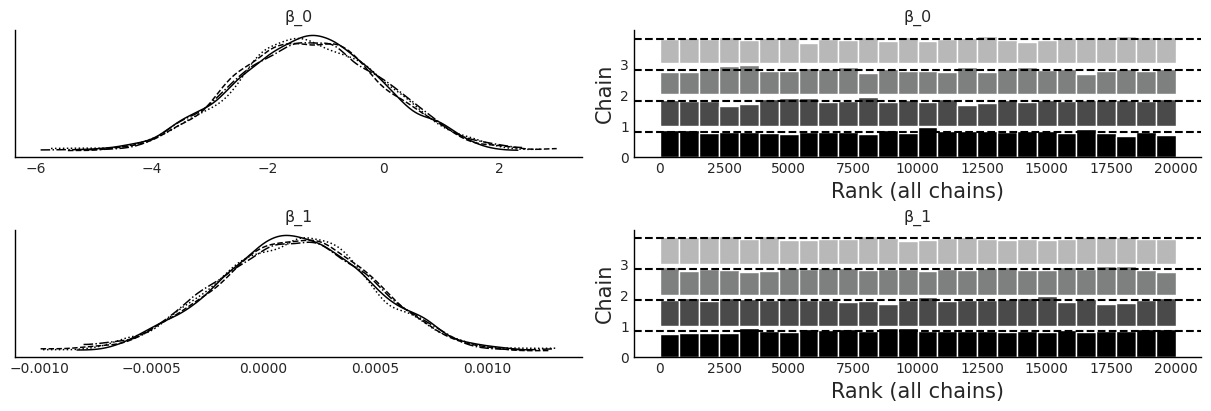

In [68]:
az.plot_trace(inf_data_logistic_penguins_mass, var_names=["β_0", "β_1"], kind="rank_bars");

In [69]:
az.summary(inf_data_logistic_penguins_mass, var_names=["β_0", "β_1", "bd"], kind="stats")

mean           sd     hdi_3%    hdi_97%
β_0     -1.281        1.272     -3.667      1.041
β_1      0.000        0.000     -0.000      0.001
bd   14108.204  1147951.275 -24544.176  30850.620

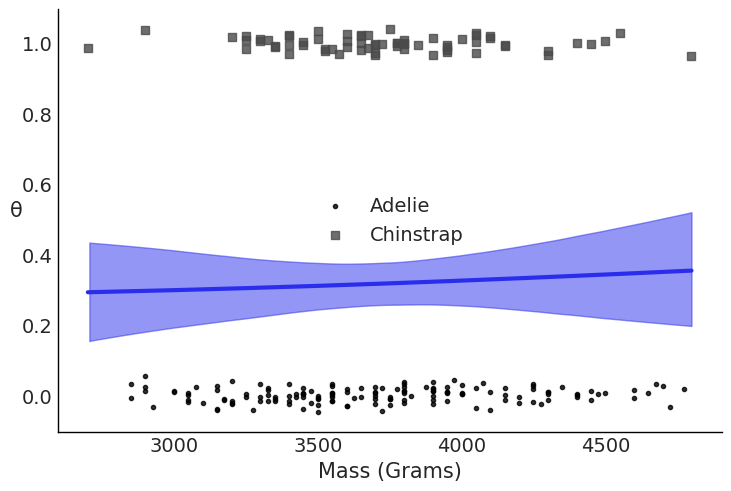

In [70]:
theta = inf_data_logistic_penguins_mass.posterior['θ'].values
bd = inf_data_logistic_penguins_mass.posterior['bd'].values


fig, ax = plt.subplots()
theta = theta.reshape(-1,214).mean(axis=0)
idx = np.argsort(mass_obs)

ax.plot(mass_obs[idx], theta[idx], color='C4', lw=3)
for i, (label, marker) in enumerate(zip(species.categories, (".", "s"))):
    _filter = (species.codes == i)
    x = mass_obs[_filter]
    y = np.random.normal(i, 0.02, size=_filter.sum())
    ax.scatter(mass_obs[_filter], y, marker=marker, label=label, alpha=.8)

az.plot_hdi(mass_obs, inf_data_logistic_penguins_mass.posterior['θ'], color='C4', ax=ax)

ax.set_xlabel("Mass (Grams)")
ax.set_ylabel('θ', rotation=0)
plt.legend()

plt.savefig("img/chp03/logistic_mass.png")

### Mass and Bill Length

In [73]:
X = penguins.loc[species_filter, ["bill_length_mm", "body_mass_g"]]

# Add a column of 1s for the intercept
X.insert(0,"Intercept", value=1)
X = X.values

with pm.Model() as model_logistic_penguins_bill_length_mass:
    β = pm.Normal('β', mu=0, sd=20, shape=3)
    
    μ = pm.math.dot(X, β)  

    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    bd = pm.Deterministic('bd', -β[0]/β[2] - β[1]/β[2] * X[:,1])

    yl = pm.Bernoulli('p', p=θ, observed=species.codes)

    inf_data_logistic_penguins_bill_length_mass = pm.sample(1000,
                                                            target_accept=.95, 
                                                            random_seed=0,
                                                            return_inferencedata=True)
    
    trace_logistic_penguins_bill_length_mass = pm.sample(5000, random_seed=0, target_accept=.9)
    posterior_predictive_penguins_bill_length_mass = pm.sample_posterior_predictive(trace_logistic_penguins_bill_length_mass)
    inf_data_logistic_penguins_bill_length_mass = az.from_pymc3(trace=trace_logistic_penguins_bill_length_mass,
                                                    posterior_predictive=posterior_predictive_penguins_bill_length_mass)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
The number of effective samples is smaller than 25% for some parameters.
/var/folders/nf/ch8x562s5q30j7qbf07161qr0000gp/T/ipykernel_42739/1637810599.py:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_logistic_penguins_bill_length_mass = pm.sample(5000, random_seed=0, target_accept=.9)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 90 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


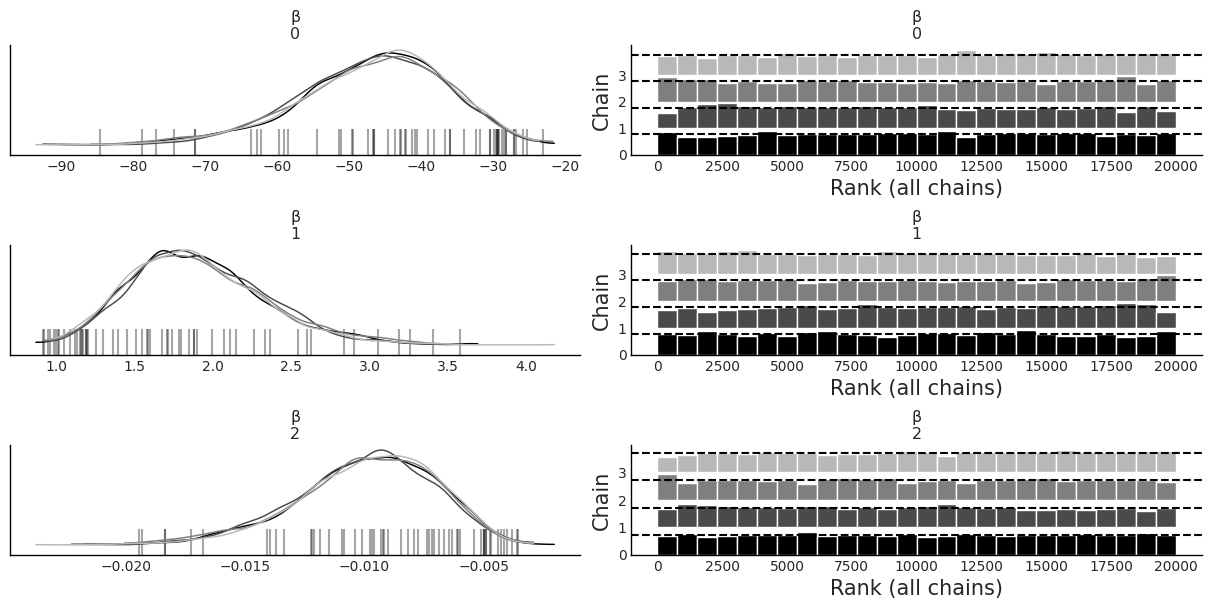

In [74]:
az.plot_trace(inf_data_logistic_penguins_bill_length_mass, compact=False, var_names=["β"], kind="rank_bars");

In [75]:
az.summary(inf_data_logistic_penguins_bill_length_mass, var_names=["β"])

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
β[0] -46.718  10.152 -66.704  -29.121      0.172    0.124    3589.0    4052.0   
β[1]   1.905   0.428   1.155    2.729      0.008    0.006    3177.0    3642.0   
β[2]  -0.010   0.003  -0.016   -0.005      0.000    0.000    3690.0    4751.0   

      r_hat  
β[0]    1.0  
β[1]    1.0  
β[2]    1.0

/Users/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


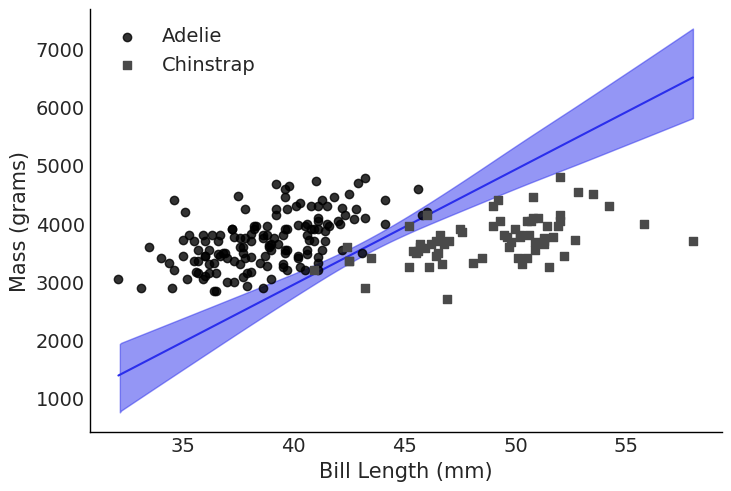

In [77]:
fig,ax  = plt.subplots()
idx = np.argsort(X[:,1]) 
bd = inf_data_logistic_penguins_bill_length_mass.posterior["bd"].values.reshape((-1,214)).mean(axis=0)[idx] 


species_filter = species.codes.astype(bool)

# Linear fit
ax.plot(X[:,1][idx], bd, color='C4'); 
az.plot_hdi(X[:,1], inf_data_logistic_penguins_bill_length_mass.posterior["bd"].values.reshape((-1,214)), color='C4', ax=ax)

# Scatter 
ax.scatter(X[~species_filter,1], X[~species_filter,2], alpha=.8,  label="Adelie", zorder=10)
ax.scatter(X[species_filter,1], X[species_filter,2], marker="s", label="Chinstrap", zorder=10)


ax.set_ylabel("Mass (grams)")
ax.set_xlabel("Bill Length (mm)")


ax.legend()
plt.savefig("img/chp03/decision_boundary_logistic_mass_bill_length.png");

### Model Comparison

In [78]:
az.compare({"mass":inf_data_logistic_penguins_mass,
            "bill": inf_data_logistic_penguins_bill_length, 
            "mass_bill":inf_data_logistic_penguins_bill_length_mass}).round(1)

/Users/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/Users/canyon/miniconda3/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank    loo  p_loo  d_loo  weight   se  dse  warning loo_scale
mass_bill     0  -11.3    1.7    0.0     1.0  3.1  0.0     True       log
bill          1  -27.0    1.7   15.6     0.0  6.2  4.9    False       log
mass          2 -135.7    1.9  124.3     0.0  5.3  5.8    False       log

In [79]:
inf_data_logistic_penguins_mass

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

### LOO PIT Plot

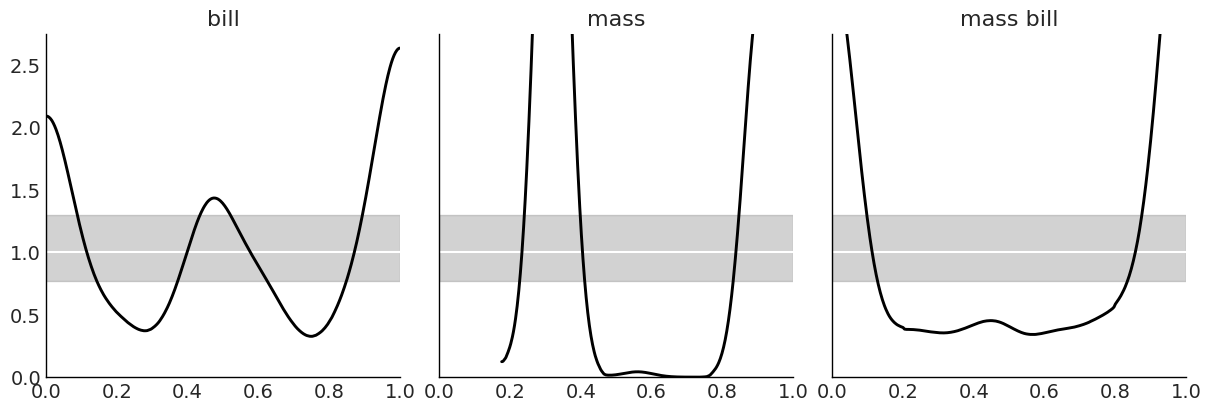

In [80]:
models = {"bill": inf_data_logistic_penguins_bill_length, 
          "mass":inf_data_logistic_penguins_mass,
          "mass bill":inf_data_logistic_penguins_bill_length_mass}

_, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for (label, model), ax in zip(models.items(), axes):
    az.plot_loo_pit(model, y="p", legend=False, use_hdi=True, ax=ax)
    ax.set_title(label)
    #ax.set_xticks([0, 0.5, 1])
    #ax.set_yticks([0, 1, 2])


### Seperation Plot

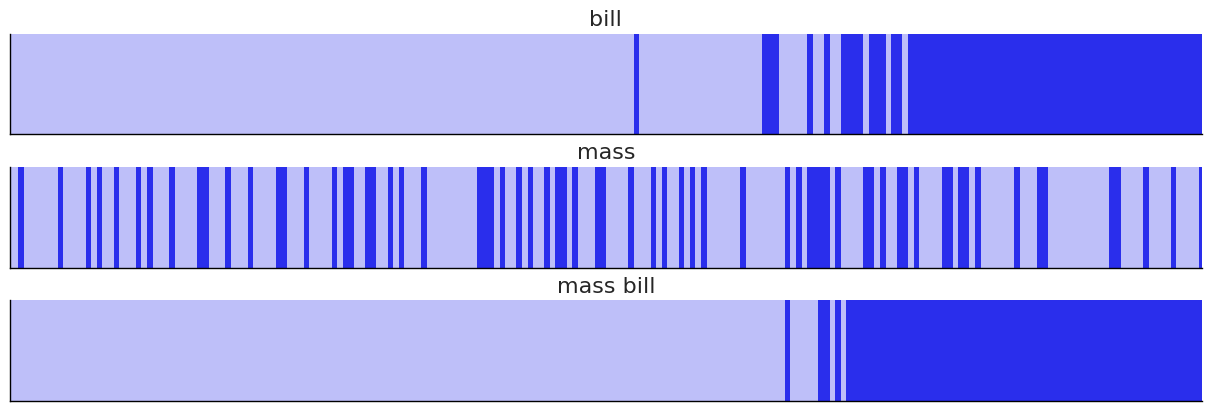

In [81]:
models = {"bill": inf_data_logistic_penguins_bill_length,
          "mass":inf_data_logistic_penguins_mass,
          "mass bill":inf_data_logistic_penguins_bill_length_mass}
_, axes = plt.subplots(3, 1, figsize=(12, 4), sharey=True)
for (label, model), ax in zip(models.items(), axes):
    az.plot_separation(model, "p", ax=ax, color="C4")
    ax.set_title(label)
    
plt.savefig("img/chp03/penguins_separation_plot.png")

### Interpreting log odds

In [82]:
penguins.loc[:,"species"].value_counts()

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64

In [83]:
counts = penguins["species"].value_counts()
adelie_count = counts["Adelie"],
chinstrap_count = counts["Chinstrap"]
adelie_count/(adelie_count+chinstrap_count)

array([0.68224299])

In [84]:
adelie_count/chinstrap_count

array([2.14705882])

In [85]:
inf_data_logistic_penguins_bill_length.posterior["β_0"].mean().values

array(-45.57832978)

In [86]:
β_0 = inf_data_logistic_penguins_bill_length.posterior["β_0"].mean().values
β_1 = inf_data_logistic_penguins_bill_length.posterior["β_1"].mean().values

In [87]:
β_0

array(-45.57832978)

In [88]:
β_1

array(1.03371379)

In [89]:
bill_length = 45
val_1 = β_0 + β_1*bill_length
val_2 = β_0 + β_1*(bill_length+1)

f"Class Probability change from 45mm Bill Length to 46mm: {(special.expit(val_2) - special.expit(val_1))*100:.0f}%"

'Class Probability change from 45mm Bill Length to 46mm: 16%'

In [90]:
bill_length = np.array([30, 45])
val_1 = β_0 + β_1*bill_length
val_2 = β_0 + β_1*(bill_length+1)

#f"Slope Change {(val_2 - val_1):.2f} Probability Change {(special.expit(val_2) - special.expit(val_1)):.2f}"

In [91]:
special.expit(val_2) - special.expit(val_1)

array([8.54482919e-07, 1.59024528e-01])

## Picking Priors

In [92]:
x = np.arange(-2,3,1)
y = [50, 44, 50, 47, 56]

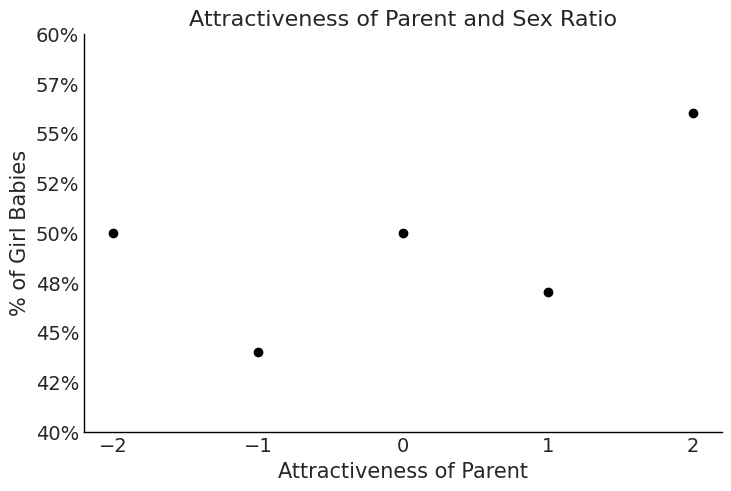

In [93]:
import matplotlib.ticker as mtick
fig, ax = plt.subplots()

ax.scatter(x, y)
ax.set_xticks(x)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
ax.set_ylim(40, 60)
ax.set_xlabel("Attractiveness of Parent")
ax.set_ylabel("% of Girl Babies")
ax.set_title("Attractiveness of Parent and Sex Ratio")
plt.savefig("img/chp03/beautyratio.png")

### Uniformative Prior

In [94]:
with pm.Model() as model_uninformative_prior_sex_ratio:
    σ = pm.Exponential("σ", .5)
    β_1 = pm.Normal("β_1", 0, 20)
    β_0 = pm.Normal("β_0", 50, 20)

    μ = pm.Deterministic("μ", β_0 + β_1*x)
    
    ratio = pm.Normal("ratio", mu=μ, sd=σ, observed = y)
    
    prior_predictive_uninformative_prior_sex_ratio = pm.sample_prior_predictive(
        samples=10000)
    trace_uninformative_prior_sex_ratio = pm.sample(random_seed=0)
    inf_data_uninformative_prior_sex_ratio = az.from_pymc3(
        trace=trace_uninformative_prior_sex_ratio,
        prior=prior_predictive_uninformative_prior_sex_ratio)

/var/folders/nf/ch8x562s5q30j7qbf07161qr0000gp/T/ipykernel_42739/2629285484.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_uninformative_prior_sex_ratio = pm.sample(random_seed=0)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_0, β_1, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


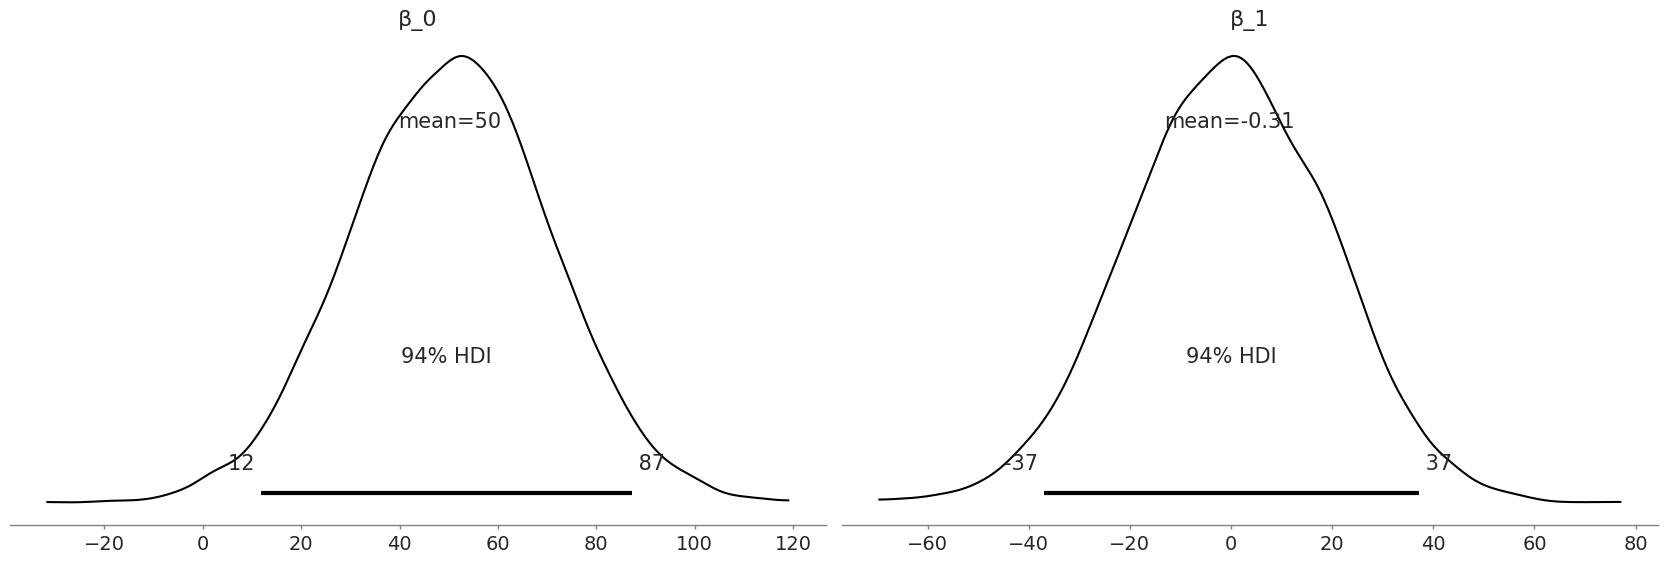

In [95]:
az.plot_posterior(inf_data_uninformative_prior_sex_ratio.prior, var_names=["β_0", "β_1"])
plt.savefig("img/chp03/priorpredictiveuninformativeKDE.png")

In [96]:
az.summary(inf_data_uninformative_prior_sex_ratio, var_names=["β_0", "β_1", "σ"], kind="stats")

mean     sd  hdi_3%  hdi_97%
β_0  49.386  2.002  45.856   53.263
β_1   1.523  1.437  -1.116    4.306
σ     4.248  1.481   1.999    6.986

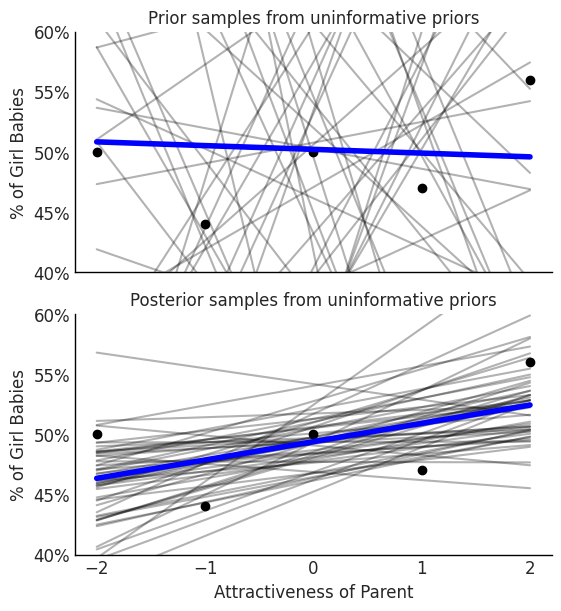

In [97]:
fig, axes = plt.subplots(2,1, figsize=(5.5, 6), sharex=True)

np.random.seed(0)
# Take 10 sample from posterior
num_samples = 50
chain_sample = inf_data_uninformative_prior_sex_ratio.prior.chain.to_series().sample(num_samples, replace=True)
draw_sample = inf_data_uninformative_prior_sex_ratio.prior.draw.to_series().sample(num_samples, replace=True)

for chain, draw in zip(chain_sample, draw_sample):
    b_0_draw = inf_data_uninformative_prior_sex_ratio.prior[{"draw":draw, "chain":chain}]["β_0"].values
    b_1_draw = inf_data_uninformative_prior_sex_ratio.prior[{"draw":draw, "chain":chain}]["β_1"].values
    
    # Plot Line
    axes[0].plot(x, b_0_draw+b_1_draw*x, c="black", alpha=.3)

# Add median line later
b_0_hat = inf_data_uninformative_prior_sex_ratio.prior["β_0"].values.mean()
b_1_hat = inf_data_uninformative_prior_sex_ratio.prior["β_1"].values.mean()

axes[0].plot(x, b_0_hat+b_1_hat*x, c="blue", linewidth=4)


# Add scatter plot
axes[0].scatter(x, y)
axes[0].set_xticks(x)
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[0].set_ylim(40, 60)
axes[0].set_ylabel("% of Girl Babies")
axes[0].set_title("Prior samples from uninformative priors")
b_0_hat, b_1_hat

np.random.seed(0)
# Take 10 sample from posterior
num_samples = 50
chain_sample = inf_data_uninformative_prior_sex_ratio.posterior.chain.to_series().sample(num_samples, replace=True)
draw_sample = inf_data_uninformative_prior_sex_ratio.posterior.draw.to_series().sample(num_samples, replace=True)

for chain, draw in zip(chain_sample, draw_sample):
    b_0_draw = inf_data_uninformative_prior_sex_ratio.posterior[{"draw":draw, "chain":chain}]["β_0"].values
    b_1_draw = inf_data_uninformative_prior_sex_ratio.posterior[{"draw":draw, "chain":chain}]["β_1"].values
    
    # Plot Line
    axes[1].plot(x, b_0_draw+b_1_draw*x, c="black", alpha=.3)

# Add median line later
b_0_hat = inf_data_uninformative_prior_sex_ratio.posterior["β_0"].values.mean()
b_1_hat = inf_data_uninformative_prior_sex_ratio.posterior["β_1"].values.mean()

axes[1].plot(x, b_0_hat+b_1_hat*x, c="blue", linewidth=4)


# Add scatter plot
axes[1].scatter(x, y)
axes[1].set_xticks(x)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[1].set_ylim(40, 60)
axes[1].set_xlabel("Attractiveness of Parent")
axes[1].set_ylabel("% of Girl Babies")
axes[1].set_title("Posterior samples from uninformative priors")
b_0_hat, b_1_hat

axes[1].title.set_fontsize(12)

for ax in axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

plt.savefig("img/chp03/posterioruninformativelinearregression.png")

### Informative Prior

In [98]:
with pm.Model() as model_informative_prior_sex_ratio:
    σ = pm.Exponential("σ", .5)
    β_1 = pm.Normal("β_1", 0, .5)
    β_0 = pm.Normal("β_0", 48.5, .5)

    μ = pm.Deterministic("μ", β_0 + β_1*x)
    
    ratio = pm.Normal("ratio", mu=μ, sd=σ, observed = y)
    
        
    prior_predictive_informative_prior_sex_ratio = pm.sample_prior_predictive(
        samples=10000)
    trace_informative_prior_sex_ratio = pm.sample(random_seed=0)
    inf_data_informative_prior_sex_ratio = az.from_pymc3(
        trace=trace_informative_prior_sex_ratio,
        prior=prior_predictive_informative_prior_sex_ratio)

/var/folders/nf/ch8x562s5q30j7qbf07161qr0000gp/T/ipykernel_42739/2266979345.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_informative_prior_sex_ratio = pm.sample(random_seed=0)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_0, β_1, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [99]:
az.summary(inf_data_informative_prior_sex_ratio, var_names=["β_0", "β_1", "σ"], kind="stats")

mean     sd  hdi_3%  hdi_97%
β_0  48.587  0.491  47.687   49.496
β_1   0.238  0.467  -0.713    1.026
σ     4.089  1.277   2.187    6.464

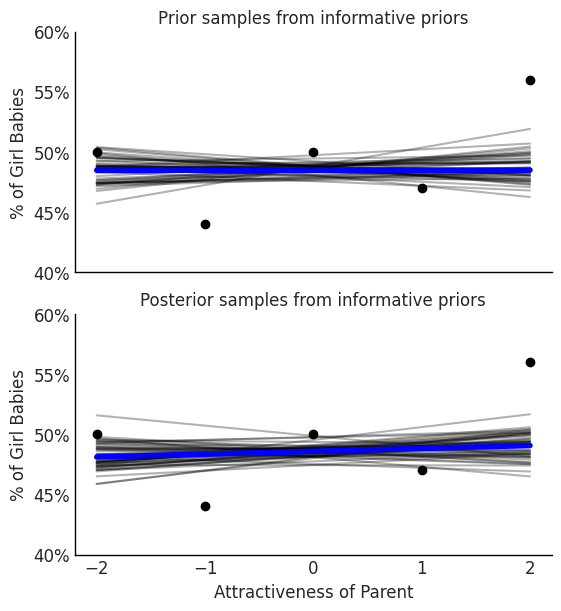

In [100]:
fig, axes = plt.subplots(2,1, figsize=(5.5, 6), sharex=True)

np.random.seed(0)
# Take 10 sample from posterior
num_samples = 50
chain_sample = inf_data_informative_prior_sex_ratio.prior.chain.to_series().sample(num_samples, replace=True)
draw_sample = inf_data_informative_prior_sex_ratio.prior.draw.to_series().sample(num_samples, replace=True)

for chain, draw in zip(chain_sample, draw_sample):
    b_0_draw = inf_data_informative_prior_sex_ratio.prior[{"draw":draw, "chain":chain}]["β_0"].values
    b_1_draw = inf_data_informative_prior_sex_ratio.prior[{"draw":draw, "chain":chain}]["β_1"].values
    
    # Plot Line
    axes[0].plot(x, b_0_draw+b_1_draw*x, c="black", alpha=.3)

# Add median line later
b_0_hat = inf_data_informative_prior_sex_ratio.prior["β_0"].values.mean()
b_1_hat = inf_data_informative_prior_sex_ratio.prior["β_1"].values.mean()

axes[0].plot(x, b_0_hat+b_1_hat*x, c="blue", linewidth=4)


# Add scatter plot
axes[0].scatter(x, y)
axes[0].set_xticks(x)
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[0].set_ylim(40, 60)
axes[0].set_ylabel("% of Girl Babies")
axes[0].set_title("Prior samples from informative priors");


np.random.seed(0)
num_samples = 50
chain_sample = inf_data_informative_prior_sex_ratio.posterior.chain.to_series().sample(num_samples, replace=True)
draw_sample = inf_data_informative_prior_sex_ratio.posterior.draw.to_series().sample(num_samples, replace=True)

for chain, draw in zip(chain_sample, draw_sample):
    b_0_draw = inf_data_informative_prior_sex_ratio.posterior[{"draw":draw, "chain":chain}]["β_0"].values
    b_1_draw = inf_data_informative_prior_sex_ratio.posterior[{"draw":draw, "chain":chain}]["β_1"].values
    
    # Plot Line
    axes[1].plot(x, b_0_draw+b_1_draw*x, c="black", alpha=.3)

# Add median line later
b_0_hat = inf_data_informative_prior_sex_ratio.posterior["β_0"].values.mean()
b_1_hat = inf_data_informative_prior_sex_ratio.posterior["β_1"].values.mean()

axes[1].plot(x, b_0_hat+b_1_hat*x, c="blue", linewidth=4)

# Add scatter plot
axes[1].scatter(x, y)
axes[1].set_xticks(x)
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
axes[1].set_ylim(40, 60)

axes[1].set_xlabel("Attractiveness of Parent")
axes[1].set_ylabel("% of Girl Babies")
axes[1].set_title("Posterior samples from informative priors")

for ax in axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

b_0_hat, b_1_hat
plt.savefig("img/chp03/posteriorinformativelinearregression.png")